In [5]:
%matplotlib inline
import re
import os
import sys
#for plotting
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import random as r
datafiles = ['ycsb_readonly_wl_2.5Mtxn_1Mrecs.out',
             'ycsb_50pwrite_th0.6_wl_2.5Mtxn_1Mrecs.out',
             'ycsb_50pwrite_th0.7_wl_2.5Mtxn_1Mrecs.out']

fname ='ycsb_50pwrite_th0.7_wl_2.5Mtxn_1Mrecs.out'
# fname ='ycsb_50pwrite_th0.7_wl_2.5Mtxn_1Mrecs.out'
# fname = 'ycsb_readonly_wl_2.5Mtxn_1Mrecs.out'
fname ='/Users/qadahtm/Dev/halstead/ycsb_wl/ycsb_wl_16_single.txt'
fname ='/Users/qadahtm/Dev/halstead/ycsb_wl/ycsb_wl_16_mpt50.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_zt9/ycsb_wl_16_single_zt9.txt'
# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_zt9/ycsb_wl_16_mpt50_zt9.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_mpt_zt9.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_mpt50_zt99.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_mpt100_zt99.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_spt_zt99_1Kdb.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_16_mpt100_zt99_1Kdb.txt'

# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8.txt'
# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb.txt'

# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt0_strict_1part_partzipf.txt'

# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt0_strict_1part_reczipf2.txt'

# fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt9_strict_1part_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt9_strict_mpt100_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt0_strict_mpt100_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt0_strict_1part_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt9_strict_1part_reczipf.txt'

fname ='/Users/qadahtm/Dev/halstead/ycsb_wl_8_1Kdb_zt9_nostrict_mpt100_reczipf.txt'


i = 0
g_max = -1
g_min = -1
PLANNER_CNT = 1

table_size = 16783200
table_size = 65536 #small table for testing
table_size = 1024 #tiny table
no_buckets = 1024
# no_buckets = 8
bucket_size = int(table_size/no_buckets)
print("Bucket size = {:d}".format(bucket_size))
buckets = [0]*no_buckets
print(buckets)

def hashKeyToBucket(key):
    for i in range(no_buckets):
#         print(i)
        if (key >= i*bucket_size and key < (i+1)*bucket_size):
            return i
#     if does not fall into any of the buckets (should not happen), assign to bucket 0

    return 0

def hashKeyToBucket2(key):
    return key % no_buckets;

def hashKeyToBucket3(key):
    return (int(key / bucket_size)) % no_buckets;

print(hashKeyToBucket(bucket_size*4))
print(hashKeyToBucket(173648))
print(hashKeyToBucket(1013625))
print(hashKeyToBucket(1048576))
print(hashKeyToBucket(1))
print(hashKeyToBucket(2))
print(hashKeyToBucket(3))

print(hashKeyToBucket2(bucket_size*4))
print(hashKeyToBucket2(173648))
print(hashKeyToBucket2(1013625))
print(hashKeyToBucket2(1048576))
print(hashKeyToBucket2(1))
print(hashKeyToBucket2(2))
print(hashKeyToBucket2(3))


#initialize planners
planners = []
for i in range(PLANNER_CNT):
    planners.append([0]*no_buckets)
print(planners)

plt_buckets_keys = []
for i in range(no_buckets):
    plt_buckets_keys.append("[{:d}-{:d})".format(i*bucket_size,bucket_size*(i+1)))
    
# plt_buckets_keys.append("[{:d}-{:d})".format(0,bucket_size))
# plt_buckets_keys.append("[{:d}-{:d})".format(bucket_size,bucket_size*2))
# plt_buckets_keys.append("[{:d}-{:d})".format(bucket_size*2,bucket_size*3))
# plt_buckets_keys.append("[{:d}-{:d})".format(bucket_size*3,bucket_size*4))

plot_data = [];
buckets_2 = [16409900, 3856648, 2650184, 2083308]
batch_size = 100*1000

def plot_figure(plt_buckets_keys, _buckets, _planners, splot):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(splot)
    pcolors = ['r','b','g','gray']
    pln_d = {};
    for i, pln in enumerate(_planners, start=0):
#         print(pln)
        for j, bkt in enumerate(_buckets, start=0):
            pln_d[plt_buckets_keys[j]] = pln[j]

#         print(pln_d)    
        x = np.arange(len(pln_d))
#         ax.bar(x+(w*(i+1)), pln_d.values(),width=w, color=pcolors[i],align='center')
        ax.bar(x, pln_d.values(), color=pcolors[i],align='center')
    
    ax.set_xticks(x)
#     ax.set_xticklabels(plt_buckets_keys, rotation=30)
    ax.set_xticklabels(x, rotation=30)
    
    ax.set_ylabel('Access Count')
    ax.set_xlabel('Key Ranges')
#     ax.autoscale(tight=True)

def parseFileForStats(_fname, planners):
    txn_cnt = 0
    _buckets = [0]*no_buckets
    
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('YCSB_TXN\{(.*)\}', cline)
            if m: #line is a transaction
                txn_str = m.group(1)
                txn_cnt = txn_cnt + 1
                keys = list(map(lambda x: int(x.split(',')[1]), txn_str.split(':')))
                for k in keys:
                    index = hashKeyToBucket3(k)
                    if (txn_cnt % 100000) == 0:
                        print("key {} is assigned to part {}".format(k, index))
                    _buckets[index] = _buckets[index] + 1                    
    print("Txn_cnt = {:d}".format(txn_cnt))
    print("Buckets:")
    print(_buckets)
                
def parseFile(_fname, planners):
    bi = 0
    plot_more = True
    plot_count = 0
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('YCSB_TXN\{(.*)\}', cline)
    #         if i < 10:
            if m: #line is a transaction
                txn_str = m.group(1)                
    #                 print(txn_str)
                pli = r.randrange(len(planners))
                keys = list(map(lambda x: int(x.split(',')[1]), txn_str.split(':')))
                for k in keys:
                    index = hashKeyToBucket(k)
#                     index = hashKeyToBucket2(k)
                    planners[pli][index] = planners[pli][index] + 1
                    buckets[index] = buckets[index] + 1        
                # increment batch
                bi = bi + 1
                if (bi == batch_size and plot_more):
                    bi = 0
                    splot = 111
#                     plot_figure(plt_buckets_keys,buckets, planners, splot)
                    planners = []
                    for i in range(PLANNER_CNT):
                        planners.append([0]*no_buckets)
                    plot_count = plot_count + 1
                if (plot_count == 1):
                    plot_more = False
                if not plot_more:
                    break

                
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)    
w = 0.19    



print("Parsing file ...")
# parseFile(datafiles[2], planners)
# parseFile(fname, planners)
# parseFileForStats(datafiles[2], planners)
parseFileForStats(fname, planners)
print("Parsing Finished!")
print(planners)
print(buckets)

# Precomputed data

def plot_figure_oneset(plt_buckets_keys, _buckets):
    plt.figure(figsize=(20,10))
    ax = plt.subplot(111)    
    x = np.arange(no_buckets)
    ax.bar(x, _buckets,width=w, color='gray',align='center')

    ax.set_xticks(x)
#     ax.set_xticklabels(plt_buckets_keys, rotation=30)
    ax.set_xticklabels(x, rotation=30)
    
    ax.set_ylabel('Access Count')
    ax.set_xlabel('Key Ranges')
#     ax.autoscale(tight=True)

buckets_0 = [6255320, 6257435, 6258752, 6228533]
buckets_1 = [14344454, 4601588, 3336508, 2717490]
buckets_2 = [16409900, 3856648, 2650184, 2083308]

planners_0 = [[3129536, 3131653, 3128575, 3118406], [3125784, 3125782, 3130177, 3110127]]
planners_1 = [[7169667, 2300193, 1667773, 1358967], [7174787, 2301395, 1668735, 1358523]]
planners_11 = [[7167936, 2299492, 1668671, 1357141], [7176518, 2302096, 1667837, 1360349]]
planners_2 = [[8209417, 1928131, 1326439, 1040283], [8200483, 1928517, 1323745, 1043025]]
planners_21 = [[8202535, 1928081, 1324651, 1040663], [8207365, 1928567, 1325533, 1042645]]

# planners = [[4103191, 964295, 661774, 519860], [4102256, 965006, 663124, 520354], [4098977, 962325, 662525, 520943],
#             [4105476, 965022, 662761, 522151]]
# plot_figure(plt_buckets_keys,buckets_0, planners_0)
# plot_figure(plt_buckets_keys,buckets_1, planners_1)
# plot_figure(plt_buckets_keys,buckets_1, planners_2)
# plot_figure_oneset(plt_buckets_keys,buckets)

Bucket size = 1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

1024


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


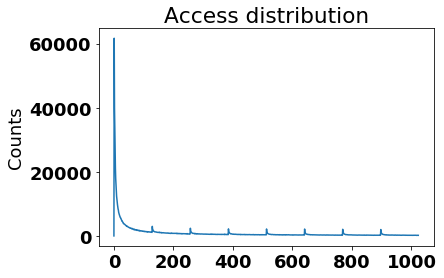

In [3]:
bb= [0, 1965, 1980, 1950, 2018, 1958, 1945, 1944, 1958, 2010, 1947, 2005, 1961, 1936, 1925, 2006, 1952, 2031, 1955, 1937, 1986, 2015, 2011, 1953, 2004, 2050, 1958, 1976, 1908, 1997, 1927, 1929, 1974, 1952, 1933, 2009, 1976, 1953, 1965, 1966, 1985, 1950, 1939, 1981, 2026, 1883, 2046, 2015, 1969, 1890, 2017, 1955, 2042, 1925, 1993, 1974, 1925, 1977, 2026, 1918, 1978, 1978, 2005, 1882, 1923, 1954, 1925, 1930, 1999, 1974, 1908, 1995, 1962, 1976, 1999, 2037, 1894, 1934, 1957, 1990, 1894, 1937, 1973, 1967, 1873, 1971, 1903, 1922, 1943, 2014, 1996, 1991, 1918, 1936, 1984, 1966, 1917, 1933, 1908, 1851, 2036, 1989, 1986, 1998, 1901, 1942, 1999, 1884, 1975, 1988, 1936, 1975, 1951, 2015, 1960, 1945, 2008, 1972, 2015, 2001, 2029, 1924, 1915, 1984, 1993, 1935, 1937, 1991, 854, 861, 855, 808, 845, 829, 817, 836, 886, 847, 804, 848, 834, 820, 861, 784, 813, 820, 902, 834, 879, 797, 811, 856, 857, 902, 846, 822, 839, 852, 825, 849, 883, 825, 842, 810, 834, 852, 807, 856, 798, 793, 810, 805, 834, 863, 824, 816, 826, 788, 848, 869, 817, 816, 860, 823, 843, 857, 843, 840, 813, 854, 846, 832, 805, 912, 874, 889, 862, 851, 788, 874, 845, 872, 847, 811, 887, 867, 825, 931, 861, 797, 851, 834, 848, 840, 848, 903, 864, 827, 823, 859, 820, 839, 846, 854, 823, 796, 802, 839, 842, 845, 853, 829, 873, 846, 851, 899, 888, 830, 781, 796, 865, 828, 826, 867, 819, 816, 832, 833, 883, 848, 834, 921, 790, 851, 804, 868, 833, 806, 854, 825, 851, 855, 817, 811, 849, 912, 867, 791, 828, 840, 920, 862, 797, 785, 855, 845, 829, 855, 898, 818, 885, 880, 820, 827, 874, 854, 831, 821, 897, 828, 812, 821, 815, 891, 840, 856, 838, 835, 792, 858, 844, 794, 859, 819, 827, 860, 816, 854, 810, 821, 829, 851, 870, 835, 822, 809, 811, 838, 848, 893, 858, 865, 848, 844, 838, 841, 837, 823, 832, 844, 827, 805, 793, 869, 841, 854, 856, 822, 826, 855, 833, 869, 847, 856, 796, 756, 852, 851, 884, 844, 811, 922, 862, 868, 860, 821, 813, 811, 874, 842, 853, 863, 842, 844, 817, 824, 849, 882, 888, 862, 850, 888, 848, 890, 839, 821, 776, 846, 838, 825, 874, 827, 880, 871, 864, 805, 818, 774, 820, 835, 816, 853, 809, 805, 863, 841, 828, 869, 834, 896, 822, 834, 847, 811, 837, 823, 831, 822, 848, 812, 815, 873, 821, 854, 820, 847, 815, 845, 844, 821, 825, 838, 822, 783, 839, 843, 838, 824, 832, 817, 882, 816, 863, 897, 823, 800, 864, 813, 844, 841, 837, 807, 820, 824, 829, 757, 892, 881, 922, 880, 817, 809, 805, 880, 847, 778, 866, 807, 885, 883, 872, 849, 850, 850, 861, 780, 837, 814, 867, 827, 849, 880, 865, 819, 839, 786, 883, 858, 829, 871, 838, 868, 878, 800, 793, 847, 874, 873, 801, 885, 857, 821, 852, 842, 840, 849, 776, 923, 825, 798, 866, 876, 867, 901, 789, 814, 853, 829, 851, 867, 883, 839, 792, 844, 853, 797, 827, 842, 877, 837, 873, 839, 835, 868, 840, 893, 834, 840, 836, 841, 805, 796, 851, 872, 874, 831, 836, 815, 807, 808, 789, 896, 832, 829, 860, 825, 818, 842, 907, 826, 867, 837, 838, 830, 812, 813, 802, 841, 812, 846, 865, 816, 853, 762, 839, 813, 808, 844, 805, 800, 792, 861, 846, 836, 824, 841, 857, 817, 844, 823, 776, 811, 819, 876, 837, 869, 817, 851, 804, 877, 789, 856, 798, 842, 851, 804, 838, 816, 870, 838, 899, 850, 847, 844, 813, 764, 869, 791, 853, 872, 823, 837, 784, 862, 813, 807, 837, 863, 837, 831, 871, 787, 801, 838, 847, 840, 864, 856, 825, 837, 818, 847, 874, 838, 867, 859, 822, 854, 811, 837, 782, 857, 817, 835, 869, 865, 886, 870, 854, 825, 834, 823, 901, 817, 853, 804, 851, 831, 851, 822, 866, 811, 822, 813, 837, 907, 808, 860, 826, 814, 818, 820, 796, 777, 829, 869, 830, 802, 854, 831, 841, 831, 815, 876, 815, 874, 812, 839, 800, 852, 827, 842, 853, 802, 865, 866, 851, 834, 817, 838, 839, 787, 818, 862, 859, 807, 844, 830, 884, 826, 812, 839, 824, 813, 800, 848, 853, 825, 870, 816, 880, 865, 852, 804, 864, 835, 871, 803, 871, 863, 801, 855, 822, 835, 830, 826, 878, 858, 827, 863, 884, 869, 796, 791, 878, 829, 808, 826, 869, 807, 815, 843, 802, 833, 900, 892, 799, 829, 833, 879, 874, 793, 871, 852, 846, 840, 822, 857, 795, 861, 836, 774, 830, 810, 842, 827, 836, 835, 795, 879, 821, 833, 868, 791, 805, 863, 875, 842, 877, 895, 833, 828, 861, 821, 871, 862, 879, 818, 792, 833, 858, 801, 855, 827, 837, 785, 857, 873, 855, 845, 834, 842, 852, 807, 839, 865, 856, 846, 853, 816, 838, 825, 792, 832, 823, 829, 821, 807, 826, 815, 870, 776, 829, 806, 815, 798, 861, 856, 809, 782, 887, 806, 808, 879, 858, 865, 800, 824, 859, 795, 814, 831, 855, 857, 820, 825, 843, 820, 820, 836, 857, 769, 853, 839, 820, 818, 768, 819, 836, 816, 815, 803, 824, 849, 839, 834, 816, 847, 811, 802, 797, 807, 850, 881, 820, 843, 852, 783, 795, 831, 816, 804, 793, 805, 839, 841, 809, 828, 779, 834, 812, 826, 832, 848, 853, 808, 820, 883, 865, 835, 813, 865, 834, 884, 894, 861, 800, 855, 851, 801, 898, 832, 890, 840, 795, 831, 884, 836, 849, 834, 883, 878, 809, 848, 880, 875, 851, 817, 828, 809, 842, 827, 843, 789, 837, 826, 828, 844, 846, 845, 836, 841, 822, 808, 823, 774, 846, 820, 805, 837, 838, 780, 804, 835, 846, 836, 809, 829, 844, 856, 796, 797, 841, 862, 819, 773, 813, 800, 871, 858, 855, 831, 843, 862, 833, 786, 832, 857, 848, 855, 835, 836, 818, 844, 852, 829, 868, 857, 876, 843, 845, 888, 847, 761, 923, 825, 840, 798, 875, 832, 807, 850, 824, 869, 839, 875, 839, 849, 858, 821, 867, 838, 804, 834]
bb = [0, 3994, 3939, 3938, 3937, 3957, 3895, 4034, 3951, 3954, 3992, 3955, 3934, 3913, 3845, 3954, 3961, 3769, 3996, 3833, 3910, 3882, 4014, 3913, 3828, 3924, 4022, 3947, 3874, 3953, 3871, 4030, 3923, 4036, 4004, 4038, 3931, 3943, 3981, 3973, 3926, 3842, 3832, 4000, 3887, 3918, 3879, 3968, 3857, 3980, 3909, 4032, 3913, 4003, 3962, 4025, 3966, 4050, 3948, 4014, 3868, 3978, 3844, 3884, 3849, 3995, 3997, 3921, 3913, 3921, 3815, 3952, 3861, 3949, 4006, 3986, 3997, 3914, 4041, 3894, 3877, 3908, 3858, 3942, 3971, 3946, 3837, 3884, 3939, 3941, 3959, 3915, 3983, 3969, 3938, 3911, 4086, 3839, 3874, 3904, 3896, 3869, 3929, 3811, 3909, 4013, 3898, 3992, 3959, 3886, 3868, 3939, 3954, 3815, 3931, 3939, 3921, 3955, 3951, 3964, 3937, 3972, 3817, 3893, 3847, 3909, 3874, 3952, 0, 570, 559, 575, 583, 566, 571, 542, 537, 583, 554, 574, 526, 590, 582, 556, 596, 589, 574, 542, 592, 568, 571, 564, 574, 595, 540, 560, 531, 561, 572, 558, 561, 524, 523, 553, 545, 519, 617, 570, 584, 556, 527, 591, 555, 591, 601, 583, 575, 554, 569, 571, 567, 597, 565, 544, 560, 562, 529, 594, 556, 616, 562, 586, 538, 530, 563, 594, 577, 522, 545, 584, 557, 550, 585, 549, 577, 560, 535, 591, 579, 564, 532, 521, 548, 570, 569, 570, 551, 580, 566, 570, 544, 555, 568, 627, 531, 571, 530, 558, 567, 570, 554, 562, 548, 551, 596, 556, 546, 605, 576, 518, 539, 565, 545, 559, 575, 560, 550, 567, 566, 570, 567, 560, 592, 542, 549, 598, 0, 602, 556, 531, 545, 554, 574, 559, 559, 593, 608, 554, 588, 541, 549, 556, 628, 601, 566, 602, 560, 540, 577, 544, 579, 582, 542, 547, 546, 559, 589, 582, 565, 564, 543, 574, 564, 551, 579, 539, 542, 595, 549, 550, 555, 562, 548, 573, 557, 569, 559, 562, 563, 586, 605, 536, 592, 591, 538, 573, 546, 581, 559, 584, 554, 572, 580, 573, 561, 585, 590, 595, 556, 577, 526, 515, 573, 524, 586, 570, 590, 552, 567, 562, 538, 597, 563, 606, 558, 575, 609, 527, 589, 636, 529, 549, 540, 557, 570, 569, 559, 586, 581, 593, 569, 569, 553, 545, 577, 562, 578, 560, 555, 566, 552, 552, 551, 587, 521, 555, 544, 578, 606, 591, 578, 556, 571, 598, 0, 570, 563, 578, 516, 570, 530, 573, 534, 588, 593, 591, 569, 561, 576, 576, 573, 576, 599, 595, 577, 557, 543, 564, 584, 613, 603, 595, 587, 541, 557, 553, 601, 592, 577, 594, 571, 544, 567, 568, 570, 599, 582, 560, 609, 597, 540, 556, 555, 566, 567, 595, 553, 591, 573, 581, 533, 547, 562, 560, 553, 569, 552, 545, 577, 568, 559, 540, 564, 574, 604, 563, 558, 533, 608, 570, 563, 574, 563, 591, 536, 575, 574, 594, 580, 581, 617, 545, 581, 611, 563, 568, 573, 564, 541, 605, 569, 529, 583, 543, 542, 580, 563, 591, 527, 540, 548, 604, 583, 563, 566, 548, 528, 530, 592, 528, 536, 563, 573, 518, 557, 534, 577, 600, 578, 549, 549, 559, 0, 571, 523, 541, 530, 584, 543, 512, 534, 564, 533, 598, 540, 572, 573, 516, 580, 538, 555, 558, 556, 536, 597, 523, 553, 549, 570, 547, 538, 558, 524, 569, 555, 559, 543, 529, 572, 566, 530, 576, 549, 546, 524, 569, 543, 539, 540, 590, 591, 548, 555, 592, 587, 525, 538, 566, 592, 586, 594, 610, 593, 555, 544, 525, 551, 539, 549, 554, 529, 536, 531, 566, 538, 542, 525, 543, 618, 576, 598, 541, 594, 575, 523, 514, 559, 524, 567, 589, 545, 575, 576, 595, 550, 575, 561, 540, 585, 592, 529, 548, 550, 558, 533, 564, 528, 543, 549, 547, 518, 561, 561, 590, 565, 595, 584, 535, 550, 583, 540, 590, 546, 476, 582, 583, 544, 620, 555, 571, 0, 603, 558, 531, 558, 567, 518, 570, 551, 574, 553, 623, 534, 580, 551, 583, 523, 571, 536, 514, 555, 536, 505, 569, 554, 521, 585, 556, 556, 561, 563, 544, 555, 578, 550, 604, 584, 572, 553, 583, 613, 555, 571, 519, 539, 498, 571, 585, 583, 541, 535, 563, 569, 553, 551, 565, 569, 568, 575, 552, 553, 537, 581, 552, 532, 593, 620, 557, 590, 549, 557, 521, 595, 579, 524, 575, 556, 569, 565, 580, 550, 531, 560, 577, 566, 577, 537, 567, 576, 547, 633, 565, 605, 591, 519, 579, 581, 533, 529, 541, 535, 549, 527, 544, 540, 568, 559, 575, 572, 580, 533, 518, 578, 560, 579, 514, 517, 579, 581, 577, 583, 603, 531, 554, 558, 539, 601, 584, 0, 565, 574, 544, 527, 606, 579, 592, 548, 592, 605, 543, 543, 577, 568, 579, 566, 573, 556, 601, 564, 533, 563, 559, 563, 551, 576, 545, 558, 558, 520, 574, 606, 566, 597, 548, 552, 576, 539, 540, 564, 558, 596, 583, 565, 560, 586, 569, 586, 565, 598, 589, 618, 576, 567, 552, 583, 578, 563, 565, 589, 588, 568, 547, 543, 555, 566, 574, 561, 581, 547, 597, 568, 550, 556, 547, 570, 593, 550, 605, 552, 560, 567, 580, 555, 547, 534, 598, 580, 586, 591, 551, 577, 563, 604, 547, 580, 584, 578, 592, 566, 551, 570, 544, 529, 600, 546, 516, 545, 570, 594, 554, 579, 549, 577, 609, 568, 557, 559, 548, 585, 589, 568, 563, 565, 536, 577, 545, 0, 564, 549, 571, 528, 549, 542, 558, 520, 537, 543, 564, 553, 540, 526, 544, 550, 588, 547, 590, 538, 527, 567, 572, 577, 551, 591, 591, 538, 606, 550, 555, 534, 536, 552, 591, 561, 592, 493, 581, 569, 573, 583, 542, 542, 573, 559, 549, 568, 554, 562, 626, 556, 544, 544, 549, 570, 600, 535, 572, 550, 574, 600, 565, 541, 548, 572, 606, 562, 560, 582, 570, 561, 547, 571, 574, 520, 540, 552, 561, 538, 535, 544, 534, 553, 560, 530, 589, 601, 565, 575, 566, 557, 569, 578, 591, 581, 557, 583, 540, 590, 550, 550, 536, 568, 577, 569, 516, 579, 549, 528, 564, 550, 570, 558, 546, 552, 574, 581, 537, 561, 585, 545, 570, 534, 571, 554, 596]
bb = [0, 1692, 1633, 1635, 1609, 1632, 1627, 1592, 1726, 1638, 1675, 1706, 1728, 1658, 1646, 1631, 1649, 1710, 1621, 1636, 1720, 1667, 1698, 1684, 1640, 1638, 1662, 1664, 1686, 1582, 1712, 1662, 1677, 1669, 1735, 1713, 1679, 1740, 1731, 1737, 1678, 1649, 1603, 1618, 1667, 1709, 1707, 1613, 1724, 1785, 1666, 1713, 1672, 1639, 1629, 1666, 1686, 1664, 1656, 1636, 1674, 1680, 1653, 1664, 1634, 1675, 1583, 1742, 1684, 1704, 1648, 1693, 1693, 1615, 1598, 1664, 1601, 1737, 1628, 1720, 1654, 1651, 1703, 1621, 1725, 1744, 1711, 1692, 1650, 1652, 1693, 1684, 1677, 1717, 1652, 1677, 1616, 1624, 1647, 1711, 1660, 1650, 1675, 1638, 1657, 1694, 1668, 1641, 1711, 1606, 1672, 1642, 1661, 1650, 1600, 1594, 1670, 1674, 1673, 1716, 1635, 1674, 1672, 1686, 1607, 1669, 1679, 1648, 0, 857, 853, 877, 895, 930, 860, 897, 858, 865, 886, 903, 898, 907, 885, 945, 890, 920, 928, 844, 905, 890, 910, 924, 896, 907, 923, 852, 865, 928, 878, 862, 853, 904, 851, 879, 883, 888, 895, 903, 874, 924, 904, 903, 893, 842, 849, 915, 894, 831, 896, 859, 910, 914, 872, 857, 922, 872, 939, 899, 837, 906, 867, 873, 889, 933, 918, 865, 910, 932, 858, 869, 903, 856, 889, 864, 878, 922, 834, 918, 847, 934, 904, 916, 870, 910, 913, 894, 867, 874, 925, 876, 881, 864, 917, 882, 886, 871, 813, 902, 846, 879, 880, 914, 933, 874, 876, 849, 903, 845, 848, 868, 879, 866, 877, 900, 890, 903, 891, 859, 835, 877, 885, 883, 824, 846, 890, 863, 0, 925, 903, 900, 899, 834, 872, 862, 939, 916, 884, 902, 875, 950, 881, 896, 880, 915, 892, 913, 899, 835, 865, 874, 888, 899, 872, 947, 883, 922, 912, 858, 897, 883, 904, 886, 824, 920, 884, 870, 867, 851, 895, 970, 915, 884, 949, 884, 910, 853, 885, 896, 917, 883, 898, 890, 926, 862, 908, 927, 916, 878, 952, 905, 925, 850, 938, 817, 885, 868, 871, 914, 834, 860, 884, 919, 885, 826, 889, 887, 917, 898, 900, 891, 855, 881, 857, 898, 873, 832, 864, 893, 888, 875, 902, 896, 820, 893, 899, 892, 862, 894, 893, 932, 894, 875, 906, 854, 902, 903, 864, 873, 851, 934, 922, 892, 877, 868, 861, 831, 932, 936, 890, 936, 909, 877, 862, 866, 0, 947, 927, 897, 871, 893, 884, 846, 860, 858, 892, 921, 874, 888, 945, 864, 926, 914, 887, 909, 875, 899, 857, 865, 869, 916, 879, 915, 888, 851, 895, 871, 915, 848, 908, 899, 882, 928, 940, 901, 885, 891, 909, 845, 857, 898, 873, 907, 890, 869, 901, 884, 935, 870, 875, 863, 876, 878, 885, 864, 904, 919, 936, 871, 891, 879, 928, 908, 875, 889, 912, 850, 864, 907, 900, 909, 924, 840, 896, 903, 866, 850, 907, 898, 874, 915, 929, 882, 887, 852, 868, 875, 855, 812, 923, 950, 922, 863, 874, 854, 866, 899, 902, 832, 864, 830, 920, 883, 891, 915, 903, 911, 910, 864, 851, 877, 849, 868, 877, 859, 792, 911, 922, 931, 896, 914, 888, 855, 0, 888, 874, 866, 888, 951, 884, 912, 837, 886, 945, 862, 937, 932, 911, 851, 892, 920, 892, 862, 860, 878, 866, 890, 779, 860, 869, 853, 914, 957, 876, 919, 912, 886, 934, 915, 904, 869, 884, 892, 879, 880, 864, 834, 921, 865, 895, 856, 933, 864, 917, 893, 837, 869, 857, 936, 850, 892, 885, 862, 942, 857, 942, 919, 870, 877, 846, 911, 883, 847, 900, 957, 853, 854, 906, 873, 919, 824, 852, 906, 918, 865, 883, 914, 921, 901, 859, 906, 903, 871, 899, 923, 890, 924, 860, 882, 919, 905, 850, 930, 903, 872, 908, 883, 848, 900, 930, 841, 859, 879, 850, 891, 882, 900, 883, 850, 833, 884, 913, 855, 908, 881, 896, 894, 912, 855, 933, 926, 0, 853, 899, 844, 901, 982, 880, 839, 917, 884, 916, 921, 881, 862, 860, 886, 872, 884, 913, 870, 908, 906, 844, 941, 873, 883, 878, 882, 886, 905, 991, 907, 896, 885, 859, 891, 868, 871, 972, 842, 917, 894, 859, 851, 942, 889, 911, 889, 925, 881, 874, 902, 889, 861, 921, 928, 857, 865, 922, 924, 900, 890, 927, 920, 867, 905, 856, 888, 934, 854, 936, 860, 902, 904, 858, 915, 907, 929, 884, 917, 869, 906, 963, 885, 841, 862, 864, 889, 918, 846, 819, 856, 899, 837, 917, 896, 839, 857, 885, 852, 828, 869, 865, 884, 869, 884, 939, 884, 911, 895, 878, 913, 860, 908, 897, 888, 871, 866, 882, 925, 920, 912, 871, 836, 949, 892, 863, 945, 0, 882, 879, 925, 901, 898, 877, 930, 852, 872, 829, 915, 829, 863, 903, 901, 863, 930, 967, 852, 903, 853, 913, 894, 899, 884, 860, 880, 842, 896, 918, 870, 788, 895, 877, 962, 843, 856, 898, 921, 876, 900, 947, 930, 878, 902, 855, 886, 867, 865, 880, 893, 892, 882, 865, 891, 834, 889, 883, 813, 942, 900, 951, 893, 827, 857, 874, 865, 898, 880, 883, 852, 874, 938, 894, 911, 885, 854, 892, 850, 889, 840, 887, 898, 962, 928, 910, 887, 888, 863, 879, 900, 873, 904, 867, 905, 902, 918, 819, 888, 858, 871, 876, 887, 908, 881, 822, 912, 870, 909, 868, 922, 889, 880, 903, 927, 868, 856, 871, 890, 917, 870, 896, 863, 921, 887, 893, 817, 0, 850, 824, 874, 868, 865, 914, 825, 913, 849, 902, 882, 883, 832, 905, 892, 880, 965, 833, 900, 841, 894, 882, 871, 907, 864, 908, 898, 877, 921, 905, 853, 874, 943, 874, 921, 879, 924, 934, 858, 888, 813, 879, 884, 912, 923, 906, 888, 864, 889, 858, 908, 902, 892, 895, 862, 908, 873, 793, 841, 807, 905, 926, 841, 887, 899, 888, 857, 922, 937, 812, 897, 878, 883, 850, 854, 844, 851, 921, 847, 883, 883, 894, 877, 864, 892, 891, 876, 850, 895, 885, 824, 893, 896, 847, 892, 875, 876, 890, 893, 866, 879, 915, 924, 906, 863, 871, 911, 883, 884, 815, 851, 939, 914, 903, 910, 863, 914, 901, 904, 902, 948, 880, 852, 855, 903, 858, 900]
bb= [125040, 125040, 125040, 125040, 125040, 125040, 125040, 125040]
bb = [0, 10362, 7565, 6701, 5474, 4595, 3843, 3459, 3221, 2760, 2487, 2413, 2132, 2038, 1869, 1739, 1722, 1555, 1533, 1474, 1436, 1378, 1245, 1248, 1199, 1184, 1098, 1180, 996, 972, 983, 966, 908, 924, 892, 833, 811, 769, 793, 773, 798, 745, 723, 734, 701, 678, 646, 658, 622, 675, 624, 607, 609, 550, 559, 543, 556, 549, 519, 552, 520, 540, 486, 529, 503, 480, 439, 491, 439, 473, 438, 416, 470, 451, 467, 356, 410, 391, 407, 422, 381, 389, 410, 394, 380, 425, 337, 395, 345, 374, 358, 343, 410, 344, 346, 385, 331, 367, 352, 345, 320, 274, 341, 363, 327, 304, 309, 291, 319, 309, 292, 328, 306, 295, 293, 311, 316, 311, 291, 278, 271, 295, 262, 259, 268, 269, 270, 251, 1226, 2836, 2057, 1917, 1663, 1574, 1502, 1411, 1435, 1401, 1370, 1281, 1289, 1259, 1351, 1248, 1266, 1230, 1221, 1250, 1172, 1166, 1138, 1176, 1116, 1200, 1139, 1131, 1089, 1113, 1072, 1065, 1096, 1078, 1058, 1009, 1044, 1008, 1042, 1035, 1015, 1067, 974, 987, 980, 1021, 988, 992, 976, 990, 975, 1007, 1021, 934, 1010, 928, 891, 908, 927, 849, 892, 887, 940, 928, 895, 877, 896, 852, 874, 894, 837, 808, 882, 868, 839, 880, 853, 872, 848, 827, 867, 818, 846, 825, 794, 778, 812, 805, 782, 805, 731, 777, 792, 841, 768, 799, 775, 781, 785, 806, 784, 761, 759, 751, 738, 768, 727, 738, 750, 729, 735, 763, 748, 694, 673, 740, 693, 707, 715, 727, 724, 732, 670, 686, 798, 717, 715, 688, 1101, 2786, 1917, 1767, 1538, 1463, 1395, 1360, 1333, 1322, 1262, 1277, 1195, 1146, 1135, 1140, 1145, 1067, 1135, 1115, 1075, 1118, 1075, 1073, 1087, 1075, 1101, 1089, 1031, 1043, 1035, 1064, 1031, 1080, 1032, 1056, 1034, 1045, 1000, 975, 970, 1021, 972, 970, 979, 1012, 979, 1001, 960, 937, 949, 941, 961, 981, 944, 1006, 960, 950, 905, 885, 933, 948, 882, 931, 880, 918, 899, 896, 881, 869, 871, 917, 879, 878, 873, 908, 845, 847, 941, 876, 920, 885, 840, 850, 859, 833, 839, 886, 805, 893, 889, 820, 805, 862, 820, 854, 875, 797, 785, 845, 795, 814, 783, 796, 798, 791, 818, 814, 781, 886, 806, 793, 816, 838, 770, 788, 843, 751, 775, 752, 809, 770, 823, 721, 770, 776, 746, 782, 1046, 2714, 1950, 1715, 1568, 1352, 1254, 1335, 1218, 1225, 1248, 1157, 1234, 1107, 1209, 1115, 1073, 1132, 1093, 1052, 1043, 1050, 1058, 1062, 1042, 1039, 1029, 1031, 1025, 1002, 1034, 1003, 1019, 1019, 995, 1000, 992, 970, 1001, 984, 1044, 989, 969, 938, 953, 950, 953, 927, 935, 951, 901, 966, 979, 914, 938, 914, 862, 941, 943, 945, 956, 930, 909, 963, 1006, 897, 918, 945, 921, 975, 868, 887, 894, 921, 874, 965, 874, 854, 882, 872, 895, 864, 914, 911, 901, 886, 843, 840, 891, 888, 890, 825, 858, 823, 872, 890, 843, 878, 839, 844, 860, 865, 889, 847, 843, 812, 821, 858, 836, 859, 802, 850, 872, 794, 803, 817, 835, 809, 816, 852, 816, 809, 766, 837, 842, 788, 797, 832, 976, 2661, 1884, 1641, 1465, 1393, 1306, 1241, 1262, 1187, 1146, 1143, 1159, 1183, 1166, 1126, 1148, 1123, 1048, 1017, 1049, 1073, 1047, 1053, 1063, 1016, 1012, 1030, 991, 975, 1015, 1008, 1010, 1008, 988, 1017, 958, 1037, 1009, 1011, 1032, 980, 977, 997, 964, 963, 855, 891, 924, 1006, 935, 987, 949, 1005, 1001, 936, 895, 932, 990, 940, 940, 937, 874, 913, 882, 918, 949, 881, 919, 948, 923, 882, 940, 917, 907, 934, 909, 901, 872, 910, 893, 908, 880, 906, 858, 832, 874, 869, 847, 900, 861, 870, 849, 894, 865, 851, 858, 800, 860, 892, 892, 887, 857, 883, 854, 855, 896, 849, 850, 829, 845, 814, 879, 894, 781, 848, 865, 906, 784, 803, 789, 804, 813, 839, 836, 799, 816, 846, 972, 2618, 1866, 1755, 1502, 1403, 1306, 1253, 1191, 1185, 1168, 1175, 1080, 1168, 1082, 1138, 1120, 1046, 1055, 1096, 1028, 1072, 1009, 1051, 1044, 1030, 1015, 995, 991, 927, 1013, 1018, 960, 963, 997, 1003, 986, 943, 1015, 997, 954, 956, 947, 994, 950, 947, 968, 935, 973, 955, 914, 922, 954, 936, 974, 945, 938, 910, 942, 944, 897, 966, 888, 930, 859, 874, 848, 881, 893, 938, 901, 872, 940, 940, 901, 904, 912, 932, 868, 911, 880, 869, 948, 894, 892, 875, 909, 920, 898, 892, 878, 896, 903, 857, 871, 894, 829, 907, 820, 856, 870, 904, 830, 891, 853, 866, 830, 906, 824, 835, 875, 858, 882, 851, 867, 933, 862, 830, 822, 864, 886, 866, 824, 870, 832, 883, 842, 847, 1003, 2695, 1813, 1654, 1444, 1386, 1339, 1274, 1213, 1198, 1182, 1150, 1060, 1080, 1110, 1136, 1029, 1081, 1023, 1051, 1035, 1065, 1018, 1040, 1043, 1016, 995, 990, 961, 998, 1010, 1026, 945, 1013, 1025, 948, 986, 976, 974, 902, 951, 954, 960, 973, 957, 955, 948, 936, 920, 899, 921, 954, 921, 981, 931, 959, 918, 922, 943, 996, 889, 958, 941, 916, 970, 922, 928, 930, 907, 867, 968, 858, 888, 990, 910, 901, 917, 928, 925, 917, 915, 861, 881, 940, 896, 864, 931, 854, 885, 914, 854, 894, 858, 913, 897, 937, 892, 911, 882, 891, 873, 868, 842, 848, 852, 909, 868, 874, 821, 853, 827, 879, 866, 869, 778, 839, 838, 848, 847, 806, 860, 841, 852, 886, 842, 872, 878, 918, 901, 2621, 1805, 1662, 1473, 1461, 1326, 1201, 1178, 1136, 1119, 1081, 1119, 1110, 1077, 1087, 1077, 1084, 1011, 1034, 1050, 1002, 1035, 1030, 1009, 980, 1051, 1023, 1027, 951, 1054, 1023, 957, 963, 953, 980, 965, 1007, 932, 953, 963, 941, 944, 990, 941, 1003, 934, 913, 959, 966, 927, 889, 921, 986, 946, 884, 934, 912, 909, 1001, 966, 926, 957, 970, 927, 886, 949, 929, 945, 837, 921, 917, 911, 921, 901, 907, 911, 878, 885, 959, 890, 923, 874, 921, 925, 901, 908, 866, 860, 905, 890, 865, 915, 877, 930, 927, 874, 867, 887, 875, 896, 852, 875, 875, 839, 879, 878, 887, 891, 814, 832, 902, 881, 844, 869, 871, 870, 901, 877, 896, 903, 859, 825, 868, 883, 825, 913, 881]
bb = [0, 30120, 17314, 14007, 10431, 8380, 7035, 6132, 5324, 4724, 4240, 3966, 3587, 3422, 3268, 3067, 2735, 2734, 2556, 2269, 2234, 2165, 2079, 1998, 1977, 1930, 1716, 1650, 1664, 1578, 1657, 1556, 1574, 1423, 1392, 1361, 1342, 1272, 1255, 1193, 1221, 1141, 1131, 1165, 1131, 1088, 1032, 1047, 975, 968, 1038, 1006, 1018, 920, 884, 944, 926, 888, 958, 791, 816, 814, 830, 815, 771, 774, 795, 786, 769, 771, 748, 736, 712, 668, 695, 683, 663, 620, 658, 648, 682, 666, 611, 630, 576, 584, 595, 626, 620, 556, 596, 561, 592, 581, 572, 548, 564, 580, 552, 535, 510, 511, 532, 536, 498, 511, 506, 474, 505, 532, 492, 463, 448, 476, 442, 474, 480, 470, 473, 438, 445, 453, 455, 452, 442, 460, 430, 422, 1226, 3022, 2177, 1931, 1725, 1651, 1551, 1503, 1442, 1349, 1309, 1354, 1290, 1318, 1232, 1196, 1212, 1231, 1196, 1222, 1178, 1179, 1190, 1154, 1141, 1048, 1083, 1091, 1065, 1045, 1042, 1075, 1022, 1061, 1048, 992, 1024, 1006, 1009, 1032, 994, 1044, 979, 1022, 990, 904, 986, 1016, 933, 953, 933, 929, 955, 957, 909, 945, 914, 862, 851, 839, 873, 892, 898, 886, 868, 838, 899, 863, 852, 910, 802, 829, 811, 861, 848, 752, 827, 822, 811, 802, 803, 765, 778, 785, 804, 762, 802, 761, 786, 776, 725, 774, 778, 758, 747, 743, 723, 745, 749, 738, 683, 737, 740, 785, 688, 733, 687, 722, 730, 713, 719, 680, 724, 700, 745, 681, 665, 716, 710, 676, 737, 662, 667, 665, 664, 698, 649, 656, 939, 2789, 1963, 1729, 1430, 1396, 1305, 1340, 1208, 1219, 1158, 1131, 1176, 1125, 1109, 1069, 1053, 1001, 1054, 1023, 1018, 1012, 1001, 945, 956, 966, 948, 946, 938, 955, 1037, 911, 904, 979, 888, 918, 920, 841, 940, 900, 901, 882, 893, 988, 907, 888, 864, 865, 881, 834, 856, 855, 848, 866, 820, 880, 801, 902, 827, 891, 865, 839, 828, 824, 842, 760, 818, 805, 813, 803, 824, 813, 828, 829, 759, 763, 759, 777, 769, 762, 798, 747, 774, 762, 787, 823, 736, 775, 734, 726, 736, 780, 727, 725, 782, 771, 720, 794, 741, 729, 732, 761, 731, 695, 698, 753, 737, 720, 712, 744, 703, 725, 723, 735, 739, 712, 701, 685, 702, 733, 679, 720, 723, 647, 701, 652, 693, 673, 872, 2665, 1888, 1617, 1497, 1428, 1209, 1176, 1152, 1131, 1067, 1017, 1038, 995, 993, 963, 970, 916, 928, 912, 995, 942, 921, 983, 924, 958, 937, 897, 894, 870, 842, 853, 861, 935, 825, 836, 891, 859, 924, 830, 877, 813, 880, 817, 842, 833, 821, 857, 853, 847, 906, 857, 840, 807, 792, 785, 815, 775, 818, 778, 824, 785, 772, 817, 769, 834, 806, 747, 818, 782, 791, 806, 794, 786, 787, 798, 758, 784, 766, 763, 737, 758, 792, 788, 748, 728, 775, 725, 753, 732, 754, 760, 753, 761, 728, 701, 770, 718, 746, 740, 682, 758, 696, 779, 734, 747, 706, 775, 744, 771, 691, 742, 774, 754, 727, 700, 708, 710, 720, 726, 671, 754, 705, 667, 784, 697, 693, 729, 766, 2676, 1832, 1558, 1423, 1274, 1179, 1161, 1152, 1062, 1065, 1061, 1003, 998, 942, 1025, 918, 979, 880, 932, 898, 878, 921, 860, 918, 898, 884, 859, 864, 807, 823, 903, 881, 862, 882, 845, 846, 811, 859, 877, 814, 811, 866, 822, 850, 833, 780, 862, 790, 787, 847, 780, 764, 796, 790, 809, 808, 824, 777, 751, 768, 746, 794, 801, 771, 805, 824, 799, 826, 764, 794, 778, 757, 775, 728, 727, 783, 729, 806, 777, 706, 764, 758, 733, 745, 768, 791, 770, 742, 810, 706, 717, 740, 735, 732, 704, 695, 734, 747, 773, 723, 742, 752, 771, 764, 714, 721, 719, 741, 771, 718, 698, 734, 713, 699, 693, 729, 745, 741, 749, 726, 689, 712, 659, 670, 661, 693, 677, 771, 2605, 1833, 1543, 1407, 1309, 1189, 1082, 1092, 1052, 1064, 990, 944, 984, 946, 928, 950, 965, 921, 951, 938, 887, 855, 867, 890, 875, 841, 875, 867, 891, 869, 833, 862, 922, 855, 831, 806, 773, 791, 850, 830, 812, 822, 773, 838, 850, 783, 788, 761, 800, 760, 802, 765, 797, 810, 751, 815, 800, 802, 806, 739, 799, 774, 787, 761, 826, 822, 761, 726, 757, 717, 717, 744, 765, 778, 770, 782, 755, 738, 766, 722, 786, 768, 790, 757, 708, 784, 758, 773, 772, 754, 773, 742, 668, 653, 724, 735, 661, 744, 750, 687, 680, 714, 702, 678, 663, 712, 736, 747, 729, 712, 725, 730, 702, 737, 712, 716, 748, 726, 736, 705, 682, 680, 713, 675, 740, 664, 698, 809, 2503, 1750, 1551, 1396, 1275, 1173, 1093, 1082, 1031, 945, 1029, 948, 945, 956, 950, 918, 968, 961, 886, 860, 866, 868, 858, 847, 856, 869, 843, 847, 849, 851, 825, 850, 825, 848, 806, 871, 781, 780, 791, 836, 819, 826, 817, 813, 788, 817, 852, 801, 770, 795, 791, 758, 788, 763, 752, 746, 820, 798, 812, 818, 800, 730, 751, 727, 826, 750, 780, 781, 775, 757, 784, 777, 758, 726, 727, 755, 781, 764, 772, 724, 735, 741, 746, 737, 759, 739, 743, 766, 720, 711, 704, 760, 726, 761, 755, 711, 703, 736, 731, 702, 688, 702, 723, 740, 732, 692, 723, 743, 664, 732, 670, 735, 736, 702, 705, 671, 744, 679, 691, 687, 706, 738, 721, 642, 668, 712, 717, 757, 2551, 1784, 1550, 1257, 1220, 1172, 1073, 1026, 1069, 968, 970, 972, 948, 930, 901, 926, 914, 916, 889, 892, 877, 833, 853, 831, 836, 864, 852, 847, 809, 848, 890, 835, 845, 771, 823, 792, 892, 798, 778, 778, 831, 784, 806, 790, 837, 765, 789, 786, 816, 735, 802, 784, 727, 801, 765, 805, 735, 767, 742, 787, 776, 744, 788, 739, 773, 759, 732, 792, 748, 785, 745, 777, 683, 771, 743, 761, 730, 725, 766, 782, 758, 720, 786, 692, 731, 747, 688, 723, 747, 719, 743, 711, 719, 672, 731, 726, 755, 745, 772, 791, 682, 695, 741, 782, 751, 710, 735, 727, 704, 710, 727, 744, 736, 744, 721, 712, 703, 707, 712, 702, 688, 727, 702, 736, 729, 674, 676]
bb = [0, 976, 929, 992, 981, 990, 998, 893, 1027, 960, 1001, 964, 1011, 965, 990, 1000, 968, 963, 929, 1002, 1022, 955, 1002, 1031, 1019, 981, 987, 1012, 970, 975, 1050, 997, 952, 1014, 1010, 1003, 947, 1034, 1004, 969, 965, 962, 989, 941, 999, 977, 933, 955, 942, 944, 991, 969, 973, 1028, 1013, 952, 1004, 993, 1006, 957, 976, 1028, 962, 1006, 984, 979, 996, 989, 1003, 978, 954, 968, 943, 975, 1058, 1051, 1003, 976, 940, 1028, 990, 995, 968, 991, 1023, 944, 932, 977, 972, 924, 956, 973, 975, 1053, 995, 1008, 1013, 1019, 1025, 958, 919, 976, 963, 952, 993, 1017, 1003, 998, 924, 1047, 1058, 987, 1032, 971, 960, 977, 1004, 1000, 922, 964, 943, 920, 975, 994, 944, 1005, 1034, 975, 856, 1015, 998, 941, 965, 935, 999, 977, 998, 927, 959, 1011, 996, 976, 1030, 943, 961, 1004, 980, 1011, 953, 980, 982, 944, 1012, 961, 958, 912, 931, 957, 984, 962, 1007, 1016, 940, 1007, 987, 986, 965, 900, 994, 945, 991, 965, 954, 1002, 987, 1017, 1000, 1006, 954, 998, 1017, 1019, 1038, 982, 993, 970, 1017, 980, 932, 978, 960, 1023, 983, 1029, 1007, 983, 985, 956, 970, 1008, 914, 959, 938, 1011, 966, 998, 977, 973, 994, 966, 955, 965, 1025, 996, 955, 935, 1038, 989, 957, 993, 1012, 958, 970, 1017, 979, 997, 903, 962, 969, 935, 998, 969, 977, 984, 1003, 985, 943, 1013, 897, 1034, 951, 1020, 959, 961, 962, 948, 973, 964, 940, 990, 1025, 951, 980, 1007, 956, 996, 887, 978, 975, 955, 957, 963, 967, 975, 970, 971, 996, 991, 976, 929, 984, 946, 1023, 962, 979, 958, 951, 973, 948, 1028, 1014, 976, 1016, 981, 938, 1000, 939, 967, 952, 1021, 962, 997, 976, 932, 1016, 996, 983, 991, 987, 936, 987, 940, 955, 967, 997, 991, 1018, 992, 985, 980, 1062, 1003, 988, 923, 1010, 957, 941, 907, 1004, 965, 948, 979, 994, 927, 956, 976, 990, 1025, 1037, 972, 944, 1030, 949, 952, 970, 1025, 957, 966, 981, 991, 996, 966, 914, 984, 1007, 993, 1034, 986, 980, 956, 967, 982, 976, 960, 999, 955, 929, 957, 1010, 949, 972, 1000, 1055, 1029, 1004, 970, 973, 954, 991, 991, 978, 992, 1032, 989, 929, 954, 1012, 942, 942, 949, 1023, 921, 944, 965, 903, 982, 1045, 943, 990, 975, 960, 949, 965, 1027, 946, 952, 946, 979, 991, 972, 920, 1010, 993, 985, 975, 999, 970, 1000, 969, 934, 960, 918, 953, 971, 958, 991, 1017, 965, 960, 985, 936, 994, 950, 959, 970, 924, 955, 908, 945, 958, 995, 993, 1002, 1038, 989, 991, 981, 979, 993, 1000, 965, 919, 946, 966, 939, 976, 945, 980, 1004, 1019, 978, 1008, 1025, 960, 1033, 1036, 979, 1002, 941, 943, 986, 966, 978, 1032, 1050, 1045, 974, 1025, 950, 969, 929, 911, 983, 988, 966, 975, 972, 992, 1013, 957, 985, 982, 1002, 908, 962, 963, 988, 971, 962, 1048, 1009, 918, 957, 1029, 962, 981, 946, 986, 993, 992, 926, 991, 993, 971, 967, 1053, 955, 969, 898, 995, 976, 996, 854, 990, 987, 962, 995, 938, 950, 1008, 959, 983, 928, 1002, 991, 970, 1024, 982, 1009, 951, 932, 989, 1068, 948, 974, 987, 953, 1000, 980, 1016, 942, 932, 938, 976, 986, 914, 985, 1016, 987, 1020, 924, 1028, 1004, 969, 997, 958, 989, 918, 969, 946, 1023, 958, 980, 974, 952, 990, 1011, 989, 1000, 973, 947, 983, 1032, 1043, 955, 974, 1004, 984, 954, 990, 976, 1017, 971, 1003, 947, 986, 969, 972, 971, 959, 969, 966, 1014, 982, 976, 964, 973, 1015, 1010, 1013, 960, 1006, 963, 1043, 965, 945, 923, 975, 987, 913, 964, 984, 1015, 1009, 977, 992, 953, 972, 960, 1004, 953, 981, 998, 975, 985, 997, 974, 978, 925, 939, 1049, 958, 990, 962, 1010, 943, 973, 920, 999, 1004, 881, 984, 966, 969, 951, 987, 967, 1012, 1020, 984, 1040, 1014, 956, 1001, 913, 1017, 974, 969, 996, 992, 1023, 1013, 1023, 999, 990, 952, 983, 1018, 971, 1052, 935, 1032, 963, 980, 953, 938, 1025, 966, 982, 949, 1057, 976, 995, 1050, 994, 1019, 961, 897, 1004, 972, 967, 1011, 990, 988, 967, 1019, 945, 993, 1002, 1008, 970, 1014, 961, 965, 1067, 950, 926, 933, 999, 1005, 1062, 928, 994, 926, 962, 924, 933, 956, 1013, 956, 978, 914, 978, 1035, 932, 939, 971, 985, 946, 989, 995, 927, 978, 975, 907, 961, 986, 975, 992, 1008, 959, 995, 1024, 979, 969, 957, 1022, 967, 927, 991, 951, 987, 976, 994, 1038, 938, 967, 1033, 1012, 963, 931, 943, 951, 1028, 934, 898, 971, 970, 895, 1030, 1003, 939, 1021, 952, 916, 951, 1018, 957, 997, 953, 1028, 996, 944, 963, 975, 986, 1008, 1017, 972, 1027, 982, 967, 997, 926, 1009, 923, 963, 1006, 937, 983, 948, 1004, 989, 985, 944, 1028, 1024, 976, 930, 978, 986, 901, 995, 946, 954, 999, 965, 1057, 993, 1033, 987, 960, 1017, 1032, 1013, 974, 963, 983, 986, 961, 971, 991, 1012, 948, 1031, 992, 972, 969, 1016, 998, 979, 921, 963, 959, 945, 981, 991, 918, 977, 955, 911, 1036, 974, 945, 986, 956, 992, 990, 921, 939, 961, 939, 1022, 973, 971, 976, 937, 977, 953, 1053, 981, 976, 986, 1049, 895, 954, 1065, 933, 953, 933, 985, 978, 1011, 1012, 960, 988, 916, 1007, 979, 954, 974, 977, 976, 988, 961, 1022, 892, 1005, 968, 949, 971, 975, 1027, 1035, 992, 977, 972, 1002, 921, 948, 960, 956, 976, 978, 938, 976, 1001, 969, 951, 1018, 989, 980, 958, 993, 980, 1003, 1020, 981, 943, 972, 994, 1005, 958, 1001, 908, 924, 922, 1004, 965, 979, 978, 1017, 979, 992, 951, 951, 975, 1049, 1009, 1011, 1010, 921, 981, 1033, 994, 1000, 990, 955, 1034, 958, 982, 927, 944, 982, 988, 953, 983, 956, 929, 1030, 1016, 1021, 968, 1004, 981, 967, 967, 969, 951, 977, 951, 990, 951, 1001, 1042, 934, 923, 973, 917, 1005, 1010, 977, 957, 961, 936, 966, 991, 982, 970, 1053, 983, 956, 951, 989, 980, 977, 1034, 976, 983, 978, 1026, 932, 971, 1022, 971, 996, 904, 975, 992, 1002, 965, 938, 972, 984]
bb = [0, 959, 1051, 1026, 960, 972, 1002, 1011, 934, 975, 1004, 988, 1011, 942, 987, 992, 1011, 997, 1033, 957, 922, 1028, 976, 954, 1042, 985, 1017, 1013, 973, 987, 1006, 1016, 987, 1000, 948, 1001, 983, 960, 966, 968, 947, 989, 992, 978, 1043, 960, 976, 1013, 995, 963, 967, 972, 943, 1036, 1009, 1023, 951, 944, 938, 987, 975, 976, 1004, 1020, 974, 972, 992, 994, 964, 927, 989, 1005, 989, 1034, 1008, 1010, 974, 971, 984, 1009, 1007, 940, 961, 986, 955, 1003, 1029, 977, 1029, 1026, 1021, 993, 964, 988, 973, 970, 991, 1010, 1009, 940, 920, 966, 952, 1015, 987, 981, 979, 1003, 931, 951, 984, 1005, 1006, 998, 964, 986, 980, 978, 981, 943, 1009, 968, 968, 970, 969, 945, 994, 994, 917, 998, 1004, 968, 999, 983, 1022, 958, 995, 970, 1023, 955, 955, 977, 1021, 970, 965, 973, 1024, 955, 968, 906, 1019, 974, 982, 980, 978, 998, 1006, 988, 1009, 963, 948, 949, 1009, 1001, 941, 923, 976, 1015, 933, 984, 1006, 997, 964, 940, 930, 940, 1007, 919, 985, 963, 946, 971, 991, 974, 1004, 935, 984, 941, 1027, 966, 987, 1015, 969, 971, 947, 950, 966, 1002, 985, 976, 992, 986, 975, 1021, 963, 992, 1045, 1017, 983, 1005, 1007, 994, 912, 956, 995, 953, 1012, 923, 943, 984, 956, 971, 982, 998, 999, 986, 997, 982, 1003, 948, 987, 1010, 955, 963, 985, 1029, 970, 1011, 998, 1006, 990, 988, 978, 977, 945, 967, 951, 933, 940, 945, 948, 935, 941, 1034, 935, 999, 854, 950, 1002, 980, 1013, 927, 929, 1026, 963, 1045, 1003, 973, 963, 945, 995, 961, 960, 895, 984, 999, 956, 940, 1040, 953, 1005, 971, 959, 972, 949, 975, 941, 1036, 975, 973, 980, 991, 997, 969, 990, 1022, 1025, 937, 972, 957, 1010, 1031, 987, 983, 985, 1001, 981, 1008, 971, 1010, 937, 954, 915, 957, 946, 970, 1022, 996, 974, 956, 965, 972, 970, 1022, 1020, 921, 1016, 984, 995, 976, 1016, 966, 990, 911, 949, 948, 979, 979, 944, 963, 1020, 957, 970, 1020, 983, 945, 978, 1024, 979, 946, 960, 959, 996, 953, 981, 1030, 968, 961, 962, 988, 1022, 1027, 1012, 956, 965, 999, 966, 1040, 973, 970, 958, 1045, 974, 1011, 1009, 1006, 942, 971, 986, 909, 947, 917, 954, 969, 873, 1004, 980, 958, 1005, 1019, 986, 980, 1006, 951, 981, 952, 1003, 975, 914, 1040, 973, 964, 978, 930, 979, 970, 926, 976, 945, 1021, 1044, 993, 969, 948, 1011, 992, 958, 961, 968, 1010, 977, 988, 892, 952, 1018, 957, 1011, 997, 999, 1015, 1024, 959, 973, 942, 988, 988, 957, 948, 954, 960, 1016, 956, 984, 997, 1031, 1002, 974, 1025, 974, 962, 962, 1040, 917, 983, 972, 957, 956, 979, 924, 971, 986, 960, 976, 1010, 975, 984, 952, 980, 1026, 1020, 946, 993, 953, 993, 961, 1026, 977, 971, 1025, 986, 987, 961, 940, 971, 984, 1048, 938, 924, 971, 954, 988, 955, 933, 973, 973, 967, 996, 935, 993, 949, 997, 1008, 1012, 931, 1003, 960, 981, 935, 1010, 1035, 968, 936, 854, 991, 977, 1015, 994, 1008, 1020, 982, 922, 936, 969, 975, 967, 1012, 1037, 995, 905, 954, 917, 1006, 923, 993, 981, 1005, 970, 978, 959, 998, 967, 1012, 957, 981, 969, 911, 986, 991, 975, 1003, 950, 932, 979, 963, 936, 1022, 984, 1005, 994, 1003, 974, 967, 986, 959, 994, 1012, 1007, 988, 1048, 961, 916, 993, 969, 935, 975, 1020, 983, 1008, 1002, 967, 1004, 1003, 1013, 957, 950, 976, 967, 951, 964, 947, 987, 974, 980, 978, 987, 975, 979, 1034, 937, 966, 981, 923, 1022, 964, 1011, 1005, 967, 971, 931, 958, 999, 983, 1077, 939, 963, 976, 984, 1017, 978, 950, 995, 927, 957, 985, 1033, 951, 943, 982, 923, 914, 983, 949, 950, 986, 960, 1030, 986, 1037, 1013, 981, 832, 1008, 963, 958, 995, 960, 1009, 946, 1026, 973, 1001, 966, 964, 991, 994, 909, 920, 951, 944, 982, 962, 962, 1016, 997, 957, 959, 982, 1016, 954, 1026, 977, 999, 956, 979, 996, 1015, 991, 995, 957, 1026, 1008, 1006, 951, 932, 992, 982, 921, 960, 990, 978, 941, 1016, 970, 967, 983, 984, 956, 934, 1013, 1013, 1003, 970, 1046, 1039, 1022, 993, 995, 966, 988, 1009, 990, 1022, 969, 944, 954, 1010, 958, 1000, 964, 946, 989, 1000, 1014, 955, 974, 939, 1023, 985, 932, 957, 1007, 945, 978, 977, 1033, 934, 967, 934, 937, 1017, 976, 998, 1052, 1002, 946, 930, 964, 949, 947, 1021, 947, 939, 971, 981, 935, 994, 969, 985, 983, 982, 961, 999, 969, 980, 954, 956, 985, 969, 892, 1015, 979, 1000, 1000, 1011, 982, 968, 1015, 938, 1010, 973, 1003, 1006, 1005, 955, 950, 973, 899, 990, 995, 971, 1001, 969, 1017, 984, 950, 920, 978, 1033, 950, 982, 954, 999, 988, 980, 984, 1004, 955, 974, 973, 1022, 1015, 974, 970, 921, 940, 995, 985, 975, 958, 983, 940, 979, 1032, 1006, 942, 968, 996, 942, 971, 982, 936, 918, 964, 1034, 957, 1093, 987, 1029, 999, 956, 977, 975, 992, 937, 988, 985, 1047, 959, 1001, 1018, 961, 976, 951, 969, 938, 967, 980, 981, 1012, 994, 910, 982, 1038, 936, 928, 968, 977, 1018, 973, 947, 981, 956, 955, 927, 991, 991, 924, 1033, 969, 1002, 989, 992, 983, 883, 964, 952, 964, 932, 989, 1040, 926, 979, 949, 985, 1033, 972, 886, 967, 979, 971, 939, 985, 986, 972, 983, 983, 942, 963, 997, 996, 946, 1026, 922, 1012, 936, 1035, 1008, 917, 996, 975, 988, 895, 931, 991, 931, 966, 1023, 1011, 1004, 974, 964, 949, 989, 991, 972, 1000, 953, 1000, 971, 997, 1034, 1013, 940, 956, 1043, 946, 955, 956, 946, 969, 1017, 968, 1026, 942, 942, 944, 955, 937, 1018, 959, 957, 935, 983, 938, 998, 998, 946, 980, 991, 957, 999, 931, 940, 988, 931, 938, 990, 972, 999, 988, 1009, 1055, 920, 1048, 994, 965, 1030, 985, 1000, 1039, 957, 942, 979, 1003, 984, 1023, 1004, 966, 924, 974, 978, 963, 1022, 962, 989, 979, 1000, 1045, 985, 968, 1001, 1004, 985, 1006, 929, 954, 977, 978, 989, 994, 908, 970, 1016, 990]
bb = [0, 10362, 7565, 6701, 5474, 4595, 3843, 3459, 3221, 2760, 2487, 2413, 2132, 2038, 1869, 1739, 1722, 1555, 1533, 1474, 1436, 1378, 1245, 1248, 1199, 1184, 1098, 1180, 996, 972, 983, 966, 908, 924, 892, 833, 811, 769, 793, 773, 798, 745, 723, 734, 701, 678, 646, 658, 622, 675, 624, 607, 609, 550, 559, 543, 556, 549, 519, 552, 520, 540, 486, 529, 503, 480, 439, 491, 439, 473, 438, 416, 470, 451, 467, 356, 410, 391, 407, 422, 381, 389, 410, 394, 380, 425, 337, 395, 345, 374, 358, 343, 410, 344, 346, 385, 331, 367, 352, 345, 320, 274, 341, 363, 327, 304, 309, 291, 319, 309, 292, 328, 306, 295, 293, 311, 316, 311, 291, 278, 271, 295, 262, 259, 268, 269, 270, 251, 1226, 2836, 2057, 1917, 1663, 1574, 1502, 1411, 1435, 1401, 1370, 1281, 1289, 1259, 1351, 1248, 1266, 1230, 1221, 1250, 1172, 1166, 1138, 1176, 1116, 1200, 1139, 1131, 1089, 1113, 1072, 1065, 1096, 1078, 1058, 1009, 1044, 1008, 1042, 1035, 1015, 1067, 974, 987, 980, 1021, 988, 992, 976, 990, 975, 1007, 1021, 934, 1010, 928, 891, 908, 927, 849, 892, 887, 940, 928, 895, 877, 896, 852, 874, 894, 837, 808, 882, 868, 839, 880, 853, 872, 848, 827, 867, 818, 846, 825, 794, 778, 812, 805, 782, 805, 731, 777, 792, 841, 768, 799, 775, 781, 785, 806, 784, 761, 759, 751, 738, 768, 727, 738, 750, 729, 735, 763, 748, 694, 673, 740, 693, 707, 715, 727, 724, 732, 670, 686, 798, 717, 715, 688, 1101, 2786, 1917, 1767, 1538, 1463, 1395, 1360, 1333, 1322, 1262, 1277, 1195, 1146, 1135, 1140, 1145, 1067, 1135, 1115, 1075, 1118, 1075, 1073, 1087, 1075, 1101, 1089, 1031, 1043, 1035, 1064, 1031, 1080, 1032, 1056, 1034, 1045, 1000, 975, 970, 1021, 972, 970, 979, 1012, 979, 1001, 960, 937, 949, 941, 961, 981, 944, 1006, 960, 950, 905, 885, 933, 948, 882, 931, 880, 918, 899, 896, 881, 869, 871, 917, 879, 878, 873, 908, 845, 847, 941, 876, 920, 885, 840, 850, 859, 833, 839, 886, 805, 893, 889, 820, 805, 862, 820, 854, 875, 797, 785, 845, 795, 814, 783, 796, 798, 791, 818, 814, 781, 886, 806, 793, 816, 838, 770, 788, 843, 751, 775, 752, 809, 770, 823, 721, 770, 776, 746, 782, 1046, 2714, 1950, 1715, 1568, 1352, 1254, 1335, 1218, 1225, 1248, 1157, 1234, 1107, 1209, 1115, 1073, 1132, 1093, 1052, 1043, 1050, 1058, 1062, 1042, 1039, 1029, 1031, 1025, 1002, 1034, 1003, 1019, 1019, 995, 1000, 992, 970, 1001, 984, 1044, 989, 969, 938, 953, 950, 953, 927, 935, 951, 901, 966, 979, 914, 938, 914, 862, 941, 943, 945, 956, 930, 909, 963, 1006, 897, 918, 945, 921, 975, 868, 887, 894, 921, 874, 965, 874, 854, 882, 872, 895, 864, 914, 911, 901, 886, 843, 840, 891, 888, 890, 825, 858, 823, 872, 890, 843, 878, 839, 844, 860, 865, 889, 847, 843, 812, 821, 858, 836, 859, 802, 850, 872, 794, 803, 817, 835, 809, 816, 852, 816, 809, 766, 837, 842, 788, 797, 832, 976, 2661, 1884, 1641, 1465, 1393, 1306, 1241, 1262, 1187, 1146, 1143, 1159, 1183, 1166, 1126, 1148, 1123, 1048, 1017, 1049, 1073, 1047, 1053, 1063, 1016, 1012, 1030, 991, 975, 1015, 1008, 1010, 1008, 988, 1017, 958, 1037, 1009, 1011, 1032, 980, 977, 997, 964, 963, 855, 891, 924, 1006, 935, 987, 949, 1005, 1001, 936, 895, 932, 990, 940, 940, 937, 874, 913, 882, 918, 949, 881, 919, 948, 923, 882, 940, 917, 907, 934, 909, 901, 872, 910, 893, 908, 880, 906, 858, 832, 874, 869, 847, 900, 861, 870, 849, 894, 865, 851, 858, 800, 860, 892, 892, 887, 857, 883, 854, 855, 896, 849, 850, 829, 845, 814, 879, 894, 781, 848, 865, 906, 784, 803, 789, 804, 813, 839, 836, 799, 816, 846, 972, 2618, 1866, 1755, 1502, 1403, 1306, 1253, 1191, 1185, 1168, 1175, 1080, 1168, 1082, 1138, 1120, 1046, 1055, 1096, 1028, 1072, 1009, 1051, 1044, 1030, 1015, 995, 991, 927, 1013, 1018, 960, 963, 997, 1003, 986, 943, 1015, 997, 954, 956, 947, 994, 950, 947, 968, 935, 973, 955, 914, 922, 954, 936, 974, 945, 938, 910, 942, 944, 897, 966, 888, 930, 859, 874, 848, 881, 893, 938, 901, 872, 940, 940, 901, 904, 912, 932, 868, 911, 880, 869, 948, 894, 892, 875, 909, 920, 898, 892, 878, 896, 903, 857, 871, 894, 829, 907, 820, 856, 870, 904, 830, 891, 853, 866, 830, 906, 824, 835, 875, 858, 882, 851, 867, 933, 862, 830, 822, 864, 886, 866, 824, 870, 832, 883, 842, 847, 1003, 2695, 1813, 1654, 1444, 1386, 1339, 1274, 1213, 1198, 1182, 1150, 1060, 1080, 1110, 1136, 1029, 1081, 1023, 1051, 1035, 1065, 1018, 1040, 1043, 1016, 995, 990, 961, 998, 1010, 1026, 945, 1013, 1025, 948, 986, 976, 974, 902, 951, 954, 960, 973, 957, 955, 948, 936, 920, 899, 921, 954, 921, 981, 931, 959, 918, 922, 943, 996, 889, 958, 941, 916, 970, 922, 928, 930, 907, 867, 968, 858, 888, 990, 910, 901, 917, 928, 925, 917, 915, 861, 881, 940, 896, 864, 931, 854, 885, 914, 854, 894, 858, 913, 897, 937, 892, 911, 882, 891, 873, 868, 842, 848, 852, 909, 868, 874, 821, 853, 827, 879, 866, 869, 778, 839, 838, 848, 847, 806, 860, 841, 852, 886, 842, 872, 878, 918, 901, 2621, 1805, 1662, 1473, 1461, 1326, 1201, 1178, 1136, 1119, 1081, 1119, 1110, 1077, 1087, 1077, 1084, 1011, 1034, 1050, 1002, 1035, 1030, 1009, 980, 1051, 1023, 1027, 951, 1054, 1023, 957, 963, 953, 980, 965, 1007, 932, 953, 963, 941, 944, 990, 941, 1003, 934, 913, 959, 966, 927, 889, 921, 986, 946, 884, 934, 912, 909, 1001, 966, 926, 957, 970, 927, 886, 949, 929, 945, 837, 921, 917, 911, 921, 901, 907, 911, 878, 885, 959, 890, 923, 874, 921, 925, 901, 908, 866, 860, 905, 890, 865, 915, 877, 930, 927, 874, 867, 887, 875, 896, 852, 875, 875, 839, 879, 878, 887, 891, 814, 832, 902, 881, 844, 869, 871, 870, 901, 877, 896, 903, 859, 825, 868, 883, 825, 913, 881]
bb = [0, 61654, 39862, 33683, 26174, 21163, 17871, 15839, 13900, 12401, 11393, 10515, 9716, 8981, 8412, 8029, 7344, 7065, 6681, 6358, 6079, 5825, 5773, 5409, 5354, 5079, 4776, 4611, 4616, 4424, 4234, 4002, 3864, 3882, 3759, 3707, 3622, 3563, 3442, 3333, 3294, 3203, 3107, 2975, 3030, 3040, 2910, 2870, 2754, 2696, 2679, 2632, 2559, 2573, 2555, 2396, 2383, 2424, 2366, 2341, 2220, 2348, 2245, 2212, 2142, 2066, 2000, 2062, 1980, 2052, 1928, 1892, 1933, 1957, 1846, 1828, 1844, 1724, 1819, 1830, 1749, 1677, 1682, 1747, 1671, 1704, 1606, 1664, 1555, 1563, 1619, 1580, 1580, 1537, 1502, 1542, 1459, 1467, 1496, 1505, 1407, 1391, 1356, 1436, 1375, 1387, 1347, 1321, 1351, 1316, 1345, 1281, 1331, 1219, 1264, 1219, 1264, 1310, 1263, 1232, 1244, 1226, 1172, 1215, 1177, 1147, 1142, 1184, 1102, 2979, 2043, 1942, 1646, 1472, 1453, 1414, 1329, 1283, 1251, 1251, 1256, 1249, 1216, 1203, 1143, 1133, 1139, 1119, 1082, 1074, 1086, 1121, 1176, 1154, 1006, 1027, 1047, 1056, 1016, 1057, 1033, 907, 972, 977, 1004, 960, 1005, 960, 961, 935, 941, 929, 905, 920, 893, 897, 899, 881, 910, 877, 877, 911, 936, 860, 839, 827, 835, 841, 823, 771, 828, 788, 789, 870, 804, 866, 801, 800, 791, 782, 777, 811, 805, 785, 792, 770, 783, 789, 800, 781, 799, 722, 779, 759, 719, 795, 741, 711, 743, 754, 718, 712, 761, 709, 716, 743, 701, 721, 633, 716, 681, 699, 687, 703, 708, 692, 681, 643, 683, 680, 695, 646, 688, 663, 621, 665, 729, 633, 670, 608, 611, 632, 631, 610, 556, 634, 612, 2388, 1566, 1345, 1171, 1031, 972, 920, 893, 785, 805, 798, 769, 763, 748, 700, 764, 665, 743, 721, 705, 645, 588, 692, 668, 696, 659, 605, 627, 642, 612, 633, 630, 601, 618, 587, 597, 616, 598, 610, 596, 569, 541, 589, 554, 561, 579, 551, 562, 553, 564, 583, 552, 545, 513, 565, 550, 558, 550, 538, 535, 539, 562, 527, 525, 545, 537, 538, 492, 573, 526, 536, 482, 558, 508, 486, 540, 513, 498, 494, 519, 506, 488, 497, 513, 484, 498, 464, 471, 502, 471, 483, 444, 490, 488, 482, 498, 505, 503, 505, 468, 459, 471, 493, 463, 506, 458, 477, 471, 468, 461, 487, 486, 472, 490, 485, 413, 515, 462, 473, 443, 493, 443, 444, 442, 446, 447, 432, 389, 2191, 1434, 1157, 1038, 887, 789, 741, 657, 689, 615, 644, 614, 599, 558, 546, 570, 509, 542, 516, 499, 492, 538, 507, 526, 490, 516, 496, 463, 465, 481, 445, 440, 457, 494, 450, 460, 461, 463, 435, 429, 489, 423, 401, 435, 449, 436, 442, 411, 433, 436, 427, 418, 396, 414, 468, 423, 402, 431, 381, 394, 414, 413, 428, 390, 395, 379, 429, 414, 413, 393, 412, 422, 425, 385, 389, 385, 402, 375, 386, 383, 371, 400, 386, 411, 380, 423, 380, 343, 396, 361, 379, 399, 360, 382, 365, 392, 383, 385, 343, 364, 378, 393, 373, 355, 363, 323, 381, 353, 370, 366, 382, 384, 326, 349, 371, 391, 359, 373, 361, 354, 324, 367, 341, 352, 349, 377, 366, 331, 2164, 1337, 1062, 889, 753, 717, 653, 613, 564, 539, 535, 512, 481, 504, 472, 459, 418, 417, 457, 449, 453, 446, 420, 382, 399, 407, 408, 382, 395, 358, 360, 401, 358, 350, 363, 382, 394, 371, 388, 329, 344, 388, 370, 331, 393, 336, 359, 334, 353, 352, 318, 342, 316, 345, 309, 349, 299, 328, 362, 348, 343, 366, 301, 339, 319, 367, 303, 350, 339, 309, 326, 315, 329, 368, 355, 308, 340, 285, 305, 306, 312, 321, 332, 312, 300, 297, 296, 321, 262, 307, 272, 311, 291, 300, 325, 302, 307, 296, 316, 313, 327, 305, 296, 311, 329, 311, 311, 308, 274, 320, 289, 294, 297, 295, 278, 276, 302, 289, 287, 291, 285, 289, 304, 306, 295, 289, 305, 252, 2146, 1192, 993, 820, 716, 585, 570, 548, 525, 517, 490, 427, 442, 441, 433, 408, 403, 403, 362, 403, 354, 361, 361, 359, 359, 360, 332, 311, 349, 346, 359, 351, 324, 320, 317, 352, 298, 300, 334, 324, 339, 313, 305, 288, 320, 287, 300, 292, 282, 320, 288, 277, 314, 308, 301, 301, 301, 295, 304, 292, 289, 270, 305, 289, 283, 272, 300, 285, 278, 271, 278, 244, 280, 291, 311, 265, 292, 269, 273, 308, 268, 286, 270, 265, 264, 273, 276, 264, 264, 276, 259, 255, 263, 283, 276, 270, 245, 253, 250, 278, 244, 230, 274, 250, 238, 268, 258, 254, 228, 230, 257, 269, 235, 252, 245, 226, 251, 254, 233, 250, 250, 239, 236, 256, 254, 226, 237, 216, 2069, 1171, 989, 771, 694, 591, 555, 552, 496, 452, 398, 419, 403, 417, 383, 375, 380, 340, 331, 335, 325, 326, 366, 325, 317, 299, 314, 310, 319, 323, 320, 292, 290, 289, 304, 291, 278, 270, 287, 271, 267, 287, 255, 267, 277, 273, 256, 260, 234, 248, 267, 254, 253, 263, 289, 282, 256, 260, 256, 258, 244, 229, 270, 254, 234, 245, 254, 241, 263, 256, 244, 255, 215, 277, 248, 255, 223, 236, 242, 248, 208, 255, 252, 238, 268, 230, 225, 240, 257, 231, 224, 245, 224, 222, 225, 259, 223, 211, 226, 209, 224, 216, 217, 231, 195, 235, 207, 232, 205, 213, 216, 234, 227, 218, 238, 231, 207, 233, 219, 207, 217, 215, 219, 235, 243, 215, 221, 202, 1994, 1178, 966, 777, 646, 559, 540, 461, 449, 453, 412, 389, 378, 370, 336, 350, 357, 343, 283, 323, 324, 284, 288, 316, 305, 308, 257, 283, 274, 281, 262, 235, 266, 260, 270, 286, 254, 245, 283, 274, 235, 272, 260, 264, 240, 258, 262, 218, 233, 254, 281, 240, 221, 219, 234, 269, 232, 230, 233, 238, 246, 234, 246, 227, 241, 213, 229, 225, 198, 212, 217, 201, 233, 223, 239, 237, 229, 220, 218, 205, 231, 220, 240, 207, 196, 223, 214, 202, 224, 200, 201, 216, 223, 204, 209, 230, 195, 217, 200, 206, 215, 213, 203, 210, 205, 189, 193, 194, 171, 198, 204, 212, 198, 209, 202, 207, 188, 214, 207, 181, 169, 199, 202, 178, 200, 198, 188]

print(len(bb))

x = np.arange(len(bb))
y = bb
# plt.bar(y_pos, bb, align='center', alpha=0.5)
# plt.xticks(y_pos, y_pos)
plt.ylabel('Counts')
plt.title('Access distribution')
 
plt.plot(x,y)


In [4]:
os.getcwd()

'/Users/qadahtm/Dev/halstead/deneva_project/deneva/pynb'

In [6]:
def extract_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        res['has_data_fixed_mode'] = False
        res['has_data_normal_mode'] = False
        for line in of:
            
            cline = line.strip()
            #extract thread_cnt
            m = re.search('g_thread_cnt\s+(\d+)', cline)
            if m:
                res['g_thread_cnt'] = m.group(1)
            #extraxct zipf_theta
            m = re.search('g_zipf_theta\s+(\d+\.\d+)', cline)
            if m:
                res['g_zipf_theta'] = m.group(1)                
                
            #extract from Pass
            m = re.search('PASS!,(.+)', cline)
#             SimTime=26.737377,total_time=26.737377,pt_time=13.400466,et_time=13.336911,
#             total_tput=625030.625000,pt_tput=1247096.875000,et_tput=1253039.750000, 
#             txn_cnt=16711680
            if m:        
#                 print(m.group(1))
                res['has_data_fixed_mode'] = True
                sline = m.group(1).split(',')
                for a in sline:
                    asline = a.strip().split('=')
#                     if asline[0] == 'SimTime':                        
#                         print(asline[1])
                    if asline[0] == 'total_time':
#                         print('====='+asline[0]+'='+asline[1])
                        res['total_time'] = asline[1];
                    if asline[0] == 'pt_time':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'et_time':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'total_tput':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'pt_tput':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'et_tput':
                        res[asline[0]] = asline[1];
                    if asline[0] == 'txn_cnt':
                        res[asline[0]] = asline[1];
            
            #extract from summary
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                res['has_data_normal_mode'] = True
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
#                     print(i,a)
                    asline = a.split('=')
                    if asline[0] == 'total_runtime':
                        res[asline[0]] = asline[1]
                    if asline[0] == 'tput':
                        res[asline[0]] = asline[1]
                    if asline[0] == 'virt_mem_usage':
                        res[asline[0]] = asline[1]
                    if asline[0] == 'phys_mem_usage':
                        res[asline[0]] = asline[1]
                        
#                         print(a)
#                 print(sline[0])
#                 print(sline[1])
#                 print(sline[2])
#     print(res)
    if not res['has_data_fixed_mode']:
        res['total_time'] = '0.0';
        res['pt_time'] = '0.0';
        res['et_time'] = '0.0';
        res['total_tput'] = '0.0';
        res['pt_tput'] = '0.0';
        res['et_tput'] = '0.0';
        res['txn_cnt'] = '0';        
    if not res['has_data_normal_mode']:
        res['total_runtime'] = '0.0';
        res['tput'] = '0';
        res['virt_mem_usage'] = '0';
        res['phys_mem_usage'] = '0';
        
        
    return res;


# directory = "/Users/qadahtm/Dev/halstead/results/quecc"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/64-2017-06-28-04-36-18-PM"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/128-2017-06-28-04-38-45-PM"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/pt6-m4-16xlarge"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/pt6-x1-x32xlarge"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_exp1"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_exp2"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_no_storage_access3"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_no_storage"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_test"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_normal_mode"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_fixed_mode_last2"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_fixed_mode_last_combined"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_no_storage_access"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_no_storage_access_combined"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_no_storage_access5"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/m4-16xlarge-normal"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/quecc_db_access"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_with_simplehash"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_with_simplehash2_eagersplit"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_eagersplit"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_lazysplit2"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_lookup_simple_eagersplit_readonly2"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_eagersplit2"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_uniform"

# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_lazysplit_uniform"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_lazysplit_bptet"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_lazysplit_ptet"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_nosplit_ptet"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_eagersplit_ptet4"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/fixed_mode_withdb_simple_nosplit_ptet3"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/2017-07-17-12-09-49-PM"

#Deneva ClientQueryQueue Initialize queries and create messages on the fly
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/2017-07-17-12-39-21-PM" 

#Intialize messages and reuse them
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/2017-07-17-01-09-40-PM"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/2017-07-17-02-42-22-PM"
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_ptet"


directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_nosplit_ptet_msgs"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_quecc_nowait_zt0zt6"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_quecc_nowait_zt9"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0_zt6_zt9"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0_zt6_zt9_tdg_commit"

# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt6_zt9_tdg_commit"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt95_zt99_tdg_commit"
# print(resFiles)

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_lads_only"

directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_payemnt_tpcc"


cc_alg_map = {'nowait':1, 'quecc':13}
x_points = [2,4,8,16]

def parse_directory(directory):
    resFiles = os.listdir(directory)
    data = {
            'cc_alg':[],
            'worker_cnt':[],
            'tput':[],
            'pa_cnt':[],
            'pa_strict':[],
            'total_tput':[],
            'commit_strategy':[],
            'pt_perc':[],
            'pt_cnt':[],
            'pt_time':[],
            'pt_tput':[],
            'et_cnt':[],
            'et_tput':[],
            'et_time':[],
            'total_runtime':[],
            'total_time':[],
            'trial_no':[],
            'seq_no':[],            
            'virt_mem_usage':[],
            'phys_mem_usage':[],
            'zipf_theta':[]
           }
    # dfcols = ['cc_alg', 'w_cnt', 'tput', 'trial_no', 'seq_no', 'zipf_theta']
    for fname in resFiles:
    #     m = re.search("(pt6_)?([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt",fname)
#         regex = "pa?(\d+)_?([A-Za-z]+)_pt(\d+)_et(\d+)_(\d+)_([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt"
#         regex = "(pa(\d+)_)?([A-Za-z]+)_pt(\d+)_et(\d+)_(\d+)_?(pptstrict|pptnonstrict)_([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt"
        regex = "(pa?(\d+)_)?([A-Za-z]+)_pt(\d+)_et(\d+)_(\d+)_?(pptstrict|pptnonstrict)?_([A-Za-z]+)_(c|s)_t(\d+)_(\d+)(_(\d+))?.txt"
        m = re.search(regex,fname)
        wthd_cnt = 0
        extracted_data = {}
        cc_alg = ''
        trial_num = 0
        seq_num = 0
        theta = 0.0
        pt_prec = 0
        pa_cnt = 0
        pa_s = False
#         print(fname)
        if m:
#             print(fname)
            pa_cnt = int(m.group(2)) if m.group(2) else 0
            comm_strat = m.group(3)
            pt_cnt = int(m.group(4))
            et_cnt = int(m.group(5))
            pt_perc = int(m.group(6))
            if m.group(7) == 'pptstrict':
                pa_s = True
            cc_alg = m.group(8)
            trial_num = m.group(10)
            seq_num = m.group(11)        
            e_data = extract_from_file(directory+'/'+fname)
            w_thd = int(e_data['g_thread_cnt'])

    #         nodemal mode
            if (comm_strat == 'NOCOMSTRAT'):        
                if (cc_alg == 'QUECC'):
                    data['worker_cnt'].append(int(e_data['g_thread_cnt'])*2)
                else:
                    data['worker_cnt'].append(int(e_data['g_thread_cnt']+1))

            if (cc_alg == 'QUECC'):
                data['worker_cnt'].append(pt_cnt+et_cnt)
            else:
                data['worker_cnt'].append(int(e_data['g_thread_cnt'])+1)


            #fixed-mode

    #         if (pt_perc == 100):
    #             data['worker_cnt'].append(pt_cnt)
    #         else:
    #             data['worker_cnt'].append(pt_cnt+et_cnt)
    #         data['worker_cnt'].append(int(e_data['g_thread_cnt']))
            data['cc_alg'].append(cc_alg)
            data['commit_strategy'].append(comm_strat)

            if (e_data['has_data_fixed_mode']):
                data['total_time'].append(float(e_data['total_time']))
                data['total_tput'].append(float(e_data['total_tput']))
                data['total_runtime'].append(float(0))
                data['tput'].append(float(0))
            else:
                data['total_runtime'].append(float(e_data['total_runtime']))
                data['tput'].append(float(e_data['tput']))
                data['total_time'].append(float(0))
                data['total_tput'].append(float(0))            

            data['virt_mem_usage'].append(int(e_data['virt_mem_usage']))
            data['phys_mem_usage'].append(int(e_data['virt_mem_usage']))
            data['pa_cnt'].append(pa_cnt)
            data['pa_strict'].append(pa_s)
            data['pt_perc'].append(pt_perc)
            data['pt_cnt'].append(pt_cnt)
            data['pt_time'].append(float(e_data['pt_time']))
            data['pt_tput'].append(float(e_data['pt_tput']))
            data['et_cnt'].append(et_cnt)
            data['et_time'].append(float(e_data['et_time']))
            data['et_tput'].append(float(e_data['et_tput']))
            data['trial_no'].append(int(trial_num))
            data['seq_no'].append(int(seq_num))
            data['zipf_theta'].append('{:.2f}'.format(float(e_data['g_zipf_theta'])))   
    return data
                
ddata = parse_directory(directory)
# print(data)
s_theta = '0.95'
s_w_thd = 32
df = pd.DataFrame(ddata)    
# group_theta = df.groupby('zipf_theta')
# df = df[df.worker_cnt!=56]
# df = df[df.worker_cnt>24]
# df = df[df.cc_alg == 'QUECC']
# df = df[df.zipf_theta == s_theta]
# df = df[df.zipf_theta == '0.0']
# df = df[df.zipf_theta == '0.6']
# df = df[df.worker_cnt == s_w_thd]
# df = df[df.commit_strategy != 'IMMEDIATE']
# df = df[df.et_tput != 0]
# df = df[df.pt_perc == 50]
# df = df[df.pt_perc != 25]
# df = df[df.pt_perc == 100]
# df = df[df.worker_cnt !=8]
# df = df[df.cc_alg != 'OCC']
df

,cc_alg,commit_strategy,et_cnt,et_time,et_tput,pa_cnt,pa_strict,phys_mem_usage,pt_cnt,pt_perc,...,pt_tput,seq_no,total_runtime,total_time,total_tput,tput,trial_no,virt_mem_usage,worker_cnt,zipf_theta
0,QUECC,AFTERBATCHCOMP,10,0.0,0.0,10,True,253864936,10,50,...,0.0,84,60.000000,0.0,0.0,4.041408e+06,0,253864936,20,0.00
1,QUECC,AFTERBATCHCOMP,10,0.0,0.0,10,True,250969064,10,50,...,0.0,85,59.987191,0.0,0.0,3.979762e+06,1,250969064,20,0.00
2,CALVIN,AFTERBATCHCOMP,20,0.0,0.0,10,True,33998364,20,100,...,0.0,24,60.000001,0.0,0.0,1.259696e+05,0,33998364,21,0.00
3,CALVIN,AFTERBATCHCOMP,20,0.0,0.0,10,True,34082332,20,100,...,0.0,25,60.000001,0.0,0.0,1.277772e+05,1,34082332,21,0.00
4,HSTORE,AFTERBATCHCOMP,20,0.0,0.0,10,True,61596236,20,100,...,0.0,4,60.000001,0.0,0.0,1.055106e+06,0,61596236,21,0.00
5,HSTORE,AFTERBATCHCOMP,20,0.0,0.0,10,True,60834380,20,100,...,0.0,5,60.000000,0.0,0.0,1.041233e+06,1,60834380,21,0.00
6,MVCC,AFTERBATCHCOMP,20,0.0,0.0,10,True,88093260,20,100,...,0.0,54,60.000000,0.0,0.0,9.565054e+05,0,88093260,21,0.00
7,MVCC,AFTERBATCHCOMP,20,0.0,0.0,10,True,89176652,20,100,...,0.0,55,60.000000,0.0,0.0,9.613671e+05,1,89176652,21,0.00
8,NOWAIT,AFTERBATCHCOMP,20,0.0,0.0,10,True,72128000,20,100,...,0.0,74,60.000000,0.0,0.0,8.650956e+05,0,72128000,21,0.00
9,NOWAIT,AFTERBATCHCOMP,20,0.0,0.0,10,True,72453632,20,100,...,0.0,75,60.000000,0.0,0.0,8.956511e+05,1,72453632,21,0.00


In [5]:
# dff.loc[dff['cc_alg'] == 'OCC']
df

NameError: name 'df' is not defined

['CALVIN', 'HSTORE', 'MVCC', 'NOWAIT', 'OCC', 'SILO', 'TIMESTAMP', 'WAITDIE']
['NEWORDER + PAYMENT, 10% MPT']
CALVIN
NEWORDER + PAYMENT, 10% MPT
HSTORE
NEWORDER + PAYMENT, 10% MPT
MVCC
NEWORDER + PAYMENT, 10% MPT
NOWAIT
NEWORDER + PAYMENT, 10% MPT
OCC
NEWORDER + PAYMENT, 10% MPT
SILO
NEWORDER + PAYMENT, 10% MPT
TIMESTAMP
NEWORDER + PAYMENT, 10% MPT
WAITDIE
NEWORDER + PAYMENT, 10% MPT
111


tput  \
cc_alg    workload                    worker_cnt pt_cnt              
CALVIN    NEWORDER + PAYMENT, 10% MPT 8          8       36,746.96   
                                      16         16      31,749.91   
                                      32         32      13,590.48   
                                      48         48      18,073.65   
                                      56         56      16,809.22   
                                      62         62      15,130.37   
HSTORE    NEWORDER + PAYMENT, 10% MPT 8          8      120,051.26   
                                      16         16     179,174.22   
                                      32         32     188,456.91   
                                      48         48     155,271.83   
                                      56         56     158,564.16   
                                      62         62     157,866.98   
MVCC      NEWORDER + PAYMENT, 10% MPT 8          8       74,727.35   
                                      16         16      58,268.82   
                                      32         32      69,821.40   
                                      48         48     232,540.25   
                                      56         56     234,776.17   
                                      62         62     235,006.66   
NOWAIT    NEWORDER + PAYMENT, 10% MPT 8          8       87,203.17   
                                      16         16     154,618.94   
                                      32         32     177,607.88   
                                      48         48     165,588.68   
                                      56         56     166,110.42   
                                      62         62     164,557.30   
OCC       NEWORDER + PAYMENT, 10% MPT 8          8      102,184.36   
                                      16         16     173,762.35   
                                      32         32     240,659.52   
                                      48         48     177,237.85   
                                      56         56     158,247.73   
                                      62         62     143,988.81   
SILO      NEWORDER + PAYMENT, 10% MPT 8          8       85,543.56   
                                      16         16      98,739.87   
                                      32         32     105,897.57   
                                      48         48      88,755.20   
                                      56         56      90,588.58   
                                      62         62      89,543.37   
TIMESTAMP NEWORDER + PAYMENT, 10% MPT 8          8       98,746.02   
                                      16         16     173,851.59   
                                      32         32     262,688.11   
                                      48         48     263,468.99   
                                      56         56     261,679.64   
                                      62         62     259,144.67   
WAITDIE   NEWORDER + PAYMENT, 10% MPT 8          8       82,111.29   
                                      16         16     145,005.76   
                                      32         32     177,750.42   
                                      48         48     164,912.02   
                                      56         56     164,532.57   
                                      62         62     165,517.91   

                                                         phys_mem_usage  
cc_alg    workload                    worker_cnt pt_cnt                  
CALVIN    NEWORDER + PAYMENT, 10% MPT 8          8             27344608  
                                      16         16            27404010  
                                      32         32            16242296  
                                      48         48            24310428  
                                      56         56            26912394  
                                      62   

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


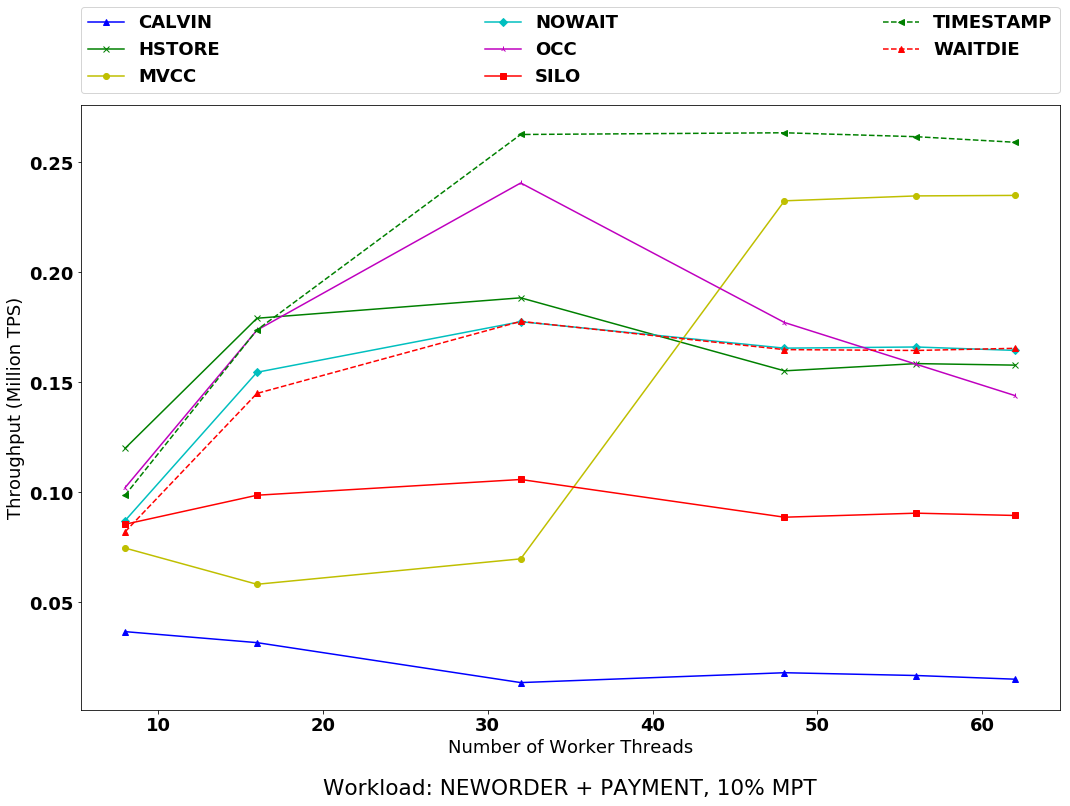

In [128]:
import matplotlib.ticker as ticker  
agg_req_normal = {'tput':'mean','phys_mem_usage':'mean'}
agg_req = agg_req_normal
us = 1000000

tpcc_set1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set1_M64"
tpcc_set2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_mix50_mpr10_set2_M64"

ycsb_wl = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/ycsb_results_october"
# df_ycsb_wl = pd.DataFrame(parse_directory(ycsb_wl))

tpcc_neworder_50_quecc_ts = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/50payment_qucc_ts_mpr15"
tpcc_neworder_50_others = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/50payment_others_mpr15"


# df_tpcc_neworder_50 = pd.concat([pd.DataFrame(parse_directory(tpcc_neworder_50_quecc_ts)),
#                                  pd.DataFrame(parse_directory(tpcc_neworder_50_others))]);
df_tpcc_test = pd.concat([pd.DataFrame(parse_directory(tpcc_set1)), pd.DataFrame(parse_directory(tpcc_set2))])

# tpcc_neworder_only = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_neworder_tpcc_mpt_o3"
# df_tpcc_neworder_only = pd.DataFrame(parse_directory(tpcc_neworder_only))

# tpcc_d15_mix50 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_d15_mix50"
# tpcc_d15_mix50_quecc = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/tpcc_d15_mix50_quecc"
# df_tmp = pd.DataFrame(parse_directory(tpcc_d15_mix50))
# df_tmp = df_tmp[df_tmp.cc_alg != 'QUECC']
# df_tpcc_d15_mix50 = pd.concat([df_tmp,
#                                  pd.DataFrame(parse_directory(tpcc_d15_mix50_quecc))]);

# tpcc_neworder_only_quecc = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_neworder_tpcc_mpt_quecc"
# df_tpcc_neworder_only_quecc = pd.DataFrame(parse_directory(tpcc_neworder_only_quecc))

# del df_tpcc_neworder_only['commit_strategy']
# del df_tpcc_neworder_only_quecc['commit_strategy']
# df_tpcc_neworder_only['workload'] = "NEWORDER_ONLY"
# df_tpcc_neworder_only_quecc['workload'] = "NEWORDER_ONLY"


# del df_tpcc_neworder_50['commit_strategy']
# df_tpcc_neworder_50['workload'] = "NEWORDER + PAYMENT"

# del df_tpcc_d15_mix50['commit_strategy']
# df_tpcc_d15_mix50['workload'] = "NEWORDER + PAYMENT"

del df_tpcc_test['commit_strategy']
df_tpcc_test['workload'] = "NEWORDER + PAYMENT, 10% MPT"



# del df_ycsb_wl['commit_strategy']
# df_ycsb_wl['workload'] = "YCSB"


# df_tpcc_neworder_only = df_tpcc_neworder_only[df_tpcc_neworder_only.cc_alg != 'QUECC']

# grouped_tpcc_neworder_only = df_tpcc_neworder_only.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)
# grouped_tpcc_neworder_only_quecc = df_tpcc_neworder_only_quecc.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)
# grouped_tpcc_neworder_50 = df_tpcc_neworder_50.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)


# grouped_tpcc_d15_mix15 = df_tpcc_d15_mix50.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)
grouped_tpcc_test = df_tpcc_test.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)

                    
# grouped_tpcc_neworder_only = pd.concat([grouped_tpcc_neworder_only_2, grouped_tpcc_neworder_only_quecc])
# grouped_tpcc_neworder_only = grouped_tpcc_neworder_only


# tpcc_payment_only = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_payment_tpcc_spt"
# tpcc_payment_only = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_payment_tpcc_spt_test2"
# tpcc_payment_only = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_payment_tpcc_spt_quecc"
# df_tpcc_payment_only = pd.DataFrame(parse_directory(tpcc_payment_only))
# del df_tpcc_payment_only['commit_strategy']
# df_tpcc_payment_only['workload'] = "PAYMENT_ONLY"
# df_tpcc_payment_only = df_tpcc_payment_only[df_tpcc_payment_only.cc_alg != 'QUECC']

# grouped_tpcc_payment_only = df_tpcc_payment_only.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)
# grouped_tpcc_neworder_only = df_tpcc_neworder_only.groupby(['cc_alg','workload','worker_cnt','pa_cnt']).agg(agg_req)
# grouped_ycsb_wl = df_ycsb_wl.groupby(['cc_alg','workload','worker_cnt','pt_cnt']).agg(agg_req)

pd.options.display.float_format = '{:,.2f}'.format
grouped_f = []
# grouped_f = grouped_tpcc_payment_only
# grouped_f = grouped_tpcc_neworder_only
# grouped_f = grouped_tpcc_neworder_50
# grouped_f = grouped_ycsb_wl
# grouped_f = grouped_tpcc_d15_mix15
grouped_f = grouped_tpcc_test
# print(grouped_f.loc['HSTORE','NEWORDER_ONLY'].index)
# dff = pd.concat([df_tpcc_payment_only,df_tpcc_neworder_only])


ls = ['b^-', 'gx-', 'yo-', 'cD-', 'm2-', 'rs-', 'g<--', 'r^--', 'g^--', 'c^-', 'm^-', 'y^--' ]
plt.figure(figsize=(16,10))

algs = list(grouped_f.index.levels[0])
ztheta = list(grouped_f.index.levels[1])
pc =0
print(algs)
print(ztheta)
doplot = True
for t in ztheta:
    doplot = False
    line_labels = []
    line_yvals = []
    line_xvals = []
    line_theta = []
    for a in algs:
#         ll = '{}-{}'.format(a,t)
        ll = a
        print(ll)
        print(t)
        line_labels.append(ll)
        yvals = list(grouped_f.loc[a,t]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_f.loc[a,t].index.get_level_values(0))
#         print(yvals)
#         print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
        line_theta.append(t)
    
    doplot = True

    if doplot:
        pc = pc + 1
        plti = 110 + pc
        print(plti)
    #     print(len(line_yvals))
        ax = plt.subplot(plti)
#         ax = plt.subplot() # single plot
        ax.set_title("Workload: {}".format(t), y=-0.15)
        for i in range(len(line_yvals)):
            ls_tmp = ls[i]

            ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
            ax.set_ylabel('Throughput (Million TPS)')
            # ax.set_xlabel('Zipfian Theta')
            ax.set_xlabel('Number of Worker Threads')
            
# algs = list(grouped_f.index.levels[0])
# pa_cnt = list(grouped_f.index.levels[2])  
# doplot = True
# line_labels = []
# line_yvals = []
# line_xvals = []
# line_theta = []
# for a in algs:
#         ll = a
#         print(ll)
#         line_labels.append(ll)
#         yvals = list(grouped_dfmpt.loc[a]['tput'])
#         yvals_s = list( map(lambda x : x/us, yvals))
#         xvals = list(grouped_f.loc[a].index.levels[1])
# #         print(yvals)
# #         print(xvals)
#         line_yvals.append(yvals_s)
#         line_xvals.append(xvals)
# # print(line_xvals)
# # print(line_yvals)
# # print(line_labels)
# if doplot:
#     pc = pc + 1
#     plti = 130 + pc
#     print(plti)
# #     print(len(line_yvals))
#     ax = plt.subplot(plti)
#     ax.set_title("Theta = {}".format(0.9), y=0.9)
#     for i in range(len(line_yvals)):
#         ls_tmp = ls[i]        
#         ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
#         ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
#         ax.set_ylabel('Throughput (Million TPS)')
#         # ax.set_xlabel('Zipfian Theta')
#         ax.set_xlabel('Number of Partitions')
        
plt.legend(bbox_to_anchor=(0.0, 1.02, 1.0, .102), 
           loc=8,
               ncol=3, mode="expand", borderaxespad=0.)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

grouped_f

In [7]:
### d1 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0_zt6_zt9_tdg_commit"
d2 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt95_zt99_tdg_commit"

d3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_lads_only"
d4 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_occ_only"

df1 = pd.DataFrame(parse_directory(d1))
df1 = df1[df1.cc_alg != 'OCC']
df2 = pd.DataFrame(parse_directory(d2))
df2 = df2[df2.cc_alg != 'OCC']
df3 = pd.DataFrame(parse_directory(d3))
df4 = pd.DataFrame(parse_directory(d4))

dff = pd.concat([df1,df2,df3,df4])
# dff = dff[dff.cc_alg != 'OCC']
del dff['commit_strategy']
# dff.to_csv()

NameError: name 'd1' is not defined

In [8]:
dff

NameError: name 'dff' is not defined

In [9]:
d3 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_mpt"
dfmpt = pd.DataFrame(parse_directory(d3))

dfmpt

,cc_alg,commit_strategy,et_cnt,et_time,et_tput,pa_cnt,pa_strict,pt_cnt,pt_perc,pt_time,pt_tput,seq_no,total_runtime,total_time,total_tput,tput,trial_no,virt_mem_usage,worker_cnt,zipf_theta
0,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,214,60.000000,0.0,0.0,2.907765e+06,0,130447248,32,0.90
1,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,215,60.000000,0.0,0.0,2.924208e+06,1,132372368,32,0.90
2,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,True,16,50,0.0,0.0,212,60.000000,0.0,0.0,3.192336e+06,0,36616080,32,0.90
3,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,True,16,50,0.0,0.0,213,60.000000,0.0,0.0,3.186288e+06,1,36634512,32,0.90
4,HSTORE,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,18,60.000001,0.0,0.0,1.257279e+05,0,35360796,32,0.90
5,HSTORE,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,19,60.000001,0.0,0.0,1.251336e+05,1,36528156,32,0.90
6,MVCC,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,158,60.000000,0.0,0.0,0.000000e+00,0,26351644,32,0.90
7,MVCC,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,159,60.000000,0.0,0.0,0.000000e+00,1,26370076,32,0.90
8,NOWAIT,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,74,60.000004,0.0,0.0,4.509323e+05,0,58993724,32,0.90
9,NOWAIT,AFTERBATCHCOMP,32,0.0,0.0,16,False,32,100,0.0,0.0,75,60.000000,0.0,0.0,4.517170e+05,1,59192380,32,0.90


In [10]:
d4 = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_quecc_x132xlarge"
df_quecc = pd.DataFrame(parse_directory(d4))
df_quecc

,cc_alg,commit_strategy,et_cnt,et_time,et_tput,pa_cnt,pa_strict,pt_cnt,pt_perc,pt_time,pt_tput,seq_no,total_runtime,total_time,total_tput,tput,trial_no,virt_mem_usage,worker_cnt,zipf_theta
0,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,22,60.000000,0.0,0.0,4.478880e+06,0,51273672,32,0.00
1,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,26,60.000000,0.0,0.0,3.458112e+06,0,71016148,32,0.60
2,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,30,60.000000,0.0,0.0,3.448347e+06,0,164730008,32,0.90
3,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,34,60.000000,0.0,0.0,3.333120e+06,0,135591544,32,0.95
4,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,38,60.000000,0.0,0.0,3.374784e+06,0,99166656,32,0.99
5,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,23,60.000000,0.0,0.0,4.499712e+06,1,48674760,32,0.00
6,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,27,60.000000,0.0,0.0,3.513447e+06,1,71425748,32,0.60
7,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,31,60.000000,0.0,0.0,3.395616e+06,1,168102952,32,0.90
8,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,35,60.000000,0.0,0.0,3.395616e+06,1,136572960,32,0.95
9,QUECC,AFTERBATCHCOMP,16,0.0,0.0,16,False,16,50,0.0,0.0,39,60.000000,0.0,0.0,3.493917e+06,1,103339936,32,0.99


In [266]:
dtest = dfmpt[dfmpt.cc_alg == 'HSTORE']
dtest

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/pandas/core/ops.py:798: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(x, name)(y)


TypeError: invalid type comparison

In [6]:
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
pd.options.display.float_format = '{:,.2f}'.format
# agg_req_fixed = {'total_tput':'mean', 'et_tput':'mean', 'pt_tput':'mean', 'total_time':'mean', 'pt_time':'mean', 'et_time':'mean'}
agg_req_fixed = {'et_tput':'mean'}
agg_req = agg_req_fixed
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).agg(agg_req)
grouped = df.groupby(['et_cnt']).agg(agg_req)
grouped

,et_tput
et_cnt,
4,0.00
8,0.00
12,0.00
16,0.00
18,0.00
24,0.00
32,0.00
36,0.00


In [292]:
grouped_f.loc[grouped_f.cc_alg == 'HSTORE']

AttributeError: 'DataFrame' object has no attribute 'cc_alg'

In [33]:
# df2 = df[df.zipf_theta == '0.99']
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
pd.options.display.float_format = '{:,.2f}'.format
agg_req_normal = {'tput':'mean', 'total_runtime':'mean', 'virt_mem_usage':'mean'}
agg_req = agg_req_normal
# grouped_dfmpt = dfmpt.loc[(dfmpt['pa_strict'] == False) & (dfmpt['cc_alg'] != 'MVCC') & (dfmpt['cc_alg'] != 'OCC')].groupby(['cc_alg','pa_strict','pa_cnt','zipf_theta', 'worker_cnt']).agg(agg_req)
grouped_dfmpt = dfmpt.groupby(['cc_alg','pa_strict','pa_cnt','zipf_theta', 'worker_cnt']).agg(agg_req)
grouped_f = dff.loc[(dff['cc_alg'] != 'MVCC') & (dff['cc_alg'] != 'OCC')].groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','pt_cnt', 'et_cnt']).agg(agg_req)
grouped_quecc = df_quecc.loc[(df_quecc['worker_cnt'] != 124)].groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','pt_cnt', 'et_cnt']).agg(agg_req)
# dff6 = dff[dff.zipf_theta == '0.60']
# grouped = dff6.groupby(['cc_alg','zipf_theta', 'worker_cnt']).agg(agg_req)
# dff95 = dff[dff.zipf_theta == '0.95']
# grouped = dff95.groupby(['cc_alg','zipf_theta', 'worker_cnt']).agg(agg_req)
# dff99 = dff[dff.zipf_theta == '0.99']
# grouped = dff99.groupby(['cc_alg','zipf_theta', 'worker_cnt']).agg(agg_req)
# dff32 = dff[dff.worker_cnt == 32]
# grouped = dff32.groupby(['cc_alg', 'worker_cnt','zipf_theta']).agg(agg_req)
# grouped = dfmpt.groupby(['cc_alg', 'worker_cnt','pa_cnt','zipf_theta']).agg(agg_req)

# grouped = df.groupby(['et_cnt']).agg(agg_req)
# grouped_f
# dff60
# grouped_dfmpt
grouped_quecc

NameError: name 'dfmpt' is not defined

,pt_tput,virt_mem_usage
pt_cnt,,
8,0.00,48831396
10,0.00,51229024
12,0.00,48037940
14,0.00,47929252
16,0.00,38210364
18,0.00,47638864
20,0.00,30734268
24,0.00,33494376
28,0.00,34552688


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


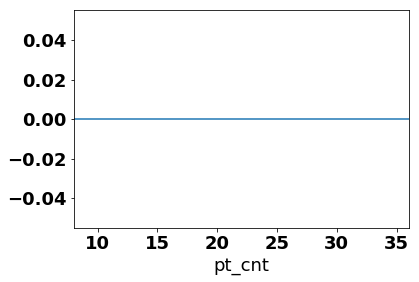

In [874]:
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
pd.options.display.float_format = '{:,.2f}'.format
# agg_req_fixed = {'total_tput':'mean', 'et_tput':'mean', 'pt_tput':'mean', 'total_time':'mean', 'pt_time':'mean', 'et_time':'mean'}
# agg_req_fixed = {'et_tput':'mean','pt_tput':'mean','virt_mem_usage':'mean'}
agg_req_fixed = {'pt_tput':'mean','virt_mem_usage':'mean'}
agg_req = agg_req_fixed
# grouped = df.groupby(['cc_alg','zipf_theta', 'worker_cnt', 'pt_perc','commit_strategy', 'pt_cnt', 'et_cnt']).agg(agg_req)
# grouped = df.groupby(['et_cnt', 'pt_cnt']).agg(agg_req)
grouped = df.groupby(['pt_cnt']).agg(agg_req)
# grouped = df.groupby(['et_cnt']).agg(agg_req)
# grouped['pt_tput'].plot()
grouped['pt_tput'].plot()
grouped

In [288]:
# no_storage_access_grouped_50 = grouped
# no_storage_access_grouped_50
csvdata = grouped_dfmpt.to_csv()
# directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_zt0"
target = open('/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/result_fig_mpt.csv','w')
target.write(csvdata)
target.close()

In [356]:
## with_storage_access_grouped_50 = grouped
# with_storage_access_grouped_50
# x = list(grouped.loc['QUECC','0.95'].index)
# x = list(grouped.loc['QUECC','0.99'].index)
# x = list(grouped.loc['QUECC','0.60'].index)

x
# grouped.loc['QUECC','0.60'].index.levels[0]
grouped_f
grouped_dfmpt.index
grouped_quecc.index
grouped_quecc.loc['QUECC','0.00'].index.levels[0]

Int64Index([16, 32, 48, 64, 80, 96, 112], dtype='int64', name='worker_cnt')

[16, 32, 48, 64, 80, 96, 112]
['0.00', '0.60', '0.90', '0.95', '0.99']
[[2.3540159767617501, 4.4730209580495002, 5.4305334802829996, 7.2680080757369998, 7.4277144883822501, 7.7159233507027496, 7.9146285289265004], [1.9325064493089998, 4.0274114844689999, 5.5168994323837497, 6.6381656051952502, 4.7627810871237495, 5.5296482334880004, 5.6709081419550005], [1.9917344782917499, 3.8213699869464999, 4.0547534308627506, 4.0278997390124998, 3.9668033868160002, 3.4748752387192501, 2.7013244827730003], [1.9432349664872501, 3.7601759856805002, 3.5916754895845, 3.7698596126645003, 3.4943726914947502, 3.77764449201675, 3.2434677828915], [1.9523489943079999, 3.7635937333942504, 3.52440546547875, 3.6272092181605, 3.5821274902610001, 3.7287109946729999, 2.8742579925339999]]
[[16, 32, 48, 64, 80, 96, 112], [16, 32, 48, 64, 80, 96, 112], [16, 32, 48, 64, 80, 96, 112], [16, 32, 48, 64, 80, 96, 112], [16, 32, 48, 64, 80, 96, 112]]


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


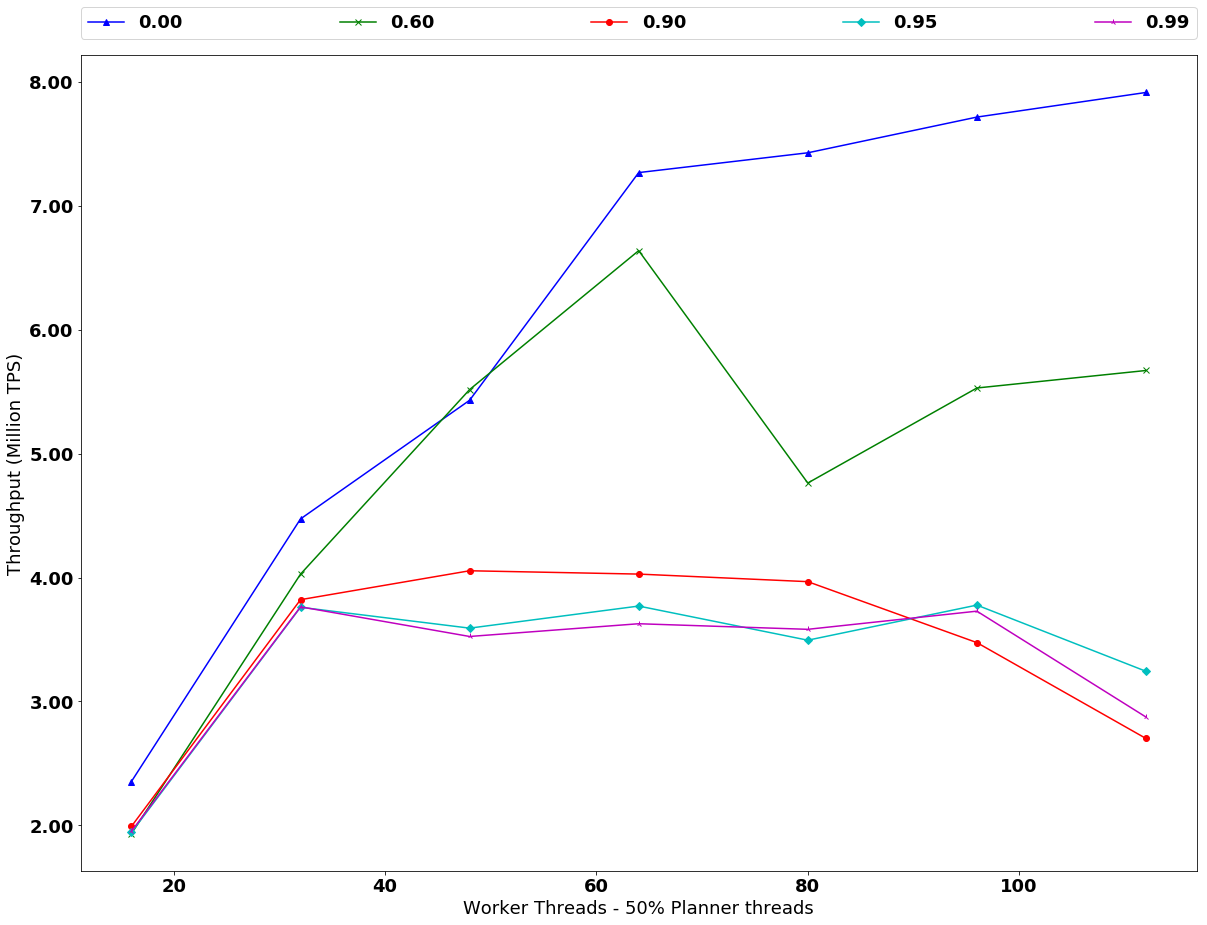

In [358]:
import matplotlib.ticker as ticker  
us = 1000000
ls = ['b^-', 'gx-', 'ro-', 'cD-', 'm2-', 'ys-', 'g<--', 'r^-', 'g^-', 'c^-', 'm^-', 'y^-' ]
x =list(grouped_quecc.index.levels[2])
keys = list(grouped_quecc.index.levels[1])
print(x)
print(keys)
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for k in keys:
    ll = str(k)
    line_labels.append(ll)
    yvals = list(grouped_quecc.loc['QUECC',k]['tput'])
    yvals_s = list( map(lambda x : x/us, yvals))
    xvals = list(grouped_quecc.loc['QUECC',k].index.levels[0])
#     print(yvals)
#     print(xvals)
    line_yvals.append(yvals_s)
    line_xvals.append(xvals)
print(line_yvals)
print(line_xvals)
plt.figure(figsize=(20,15))
ax= plt.subplot(111)
for i in range(len(line_yvals)):
        ls_tmp = ls[i]
        ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
        ax.set_ylabel('Throughput (Million TPS)')
        ax.set_xlabel('Worker Threads - 50% Planner threads')
plt.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), 
           loc=3,ncol=7, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)

In [223]:
import matplotlib.ticker as ticker  
us = 1000000
ls = ['bs-', 'rs-', 'gs-', 'cs-', 'ms-', 'ys-', 'b^-', 'r^-', 'g^-', 'c^-', 'm^-', 'y^-' ]
x =list(map(lambda x: float(x),list(grouped.loc['QUECC',32].index)))
algs = list(grouped.index.levels[0])
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for a in algs:
    ll = a
    line_labels.append(ll)
    yvals = list(grouped.loc[a,t]['tput'])
    yvals_s = list( map(lambda x : x/us, yvals))
    xvals = list(grouped.loc[a,t].index)
    print(yvals)
    print(xvals)
    line_yvals.append(yvals_s)
    line_xvals.append(xvals)
# print(line_yvals)
# print(line_xvals)
plt.figure(figsize=(20,15))
ax= plt.subplot(111)
for i in range(len(line_yvals)):
        ls_tmp = ls[i]
        ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
        ax.set_ylabel('Throughput (Million TPS)')
        ax.set_xlabel('Theta')
plt.legend(bbox_to_anchor=(0., 1.02, 1.0, .102), 
           loc=3,ncol=7, mode="expand", borderaxespad=0.)
# plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
#                     wspace=0.35)

TypeError: float() argument must be a string or a number, not 'tuple'

In [11]:
import matplotlib.ticker as ticker  
us = 1000000
ls = ['b^-', 'gx-', 'ro-', 'cD-', 'm2-', 'ys-', 'g<--', 'r^-', 'g^-', 'c^-', 'm^-', 'y^-' ]
plt.figure(figsize=(30,6))

algs = list(grouped_f.index.levels[0])
ztheta = list(grouped_f.index.levels[1])
pc =0
print(algs)
print(ztheta)
doplot = True
for t in ztheta:
    doplot = False
    line_labels = []
    line_yvals = []
    line_xvals = []
    line_theta = []
    for a in algs:
#         ll = '{}-{}'.format(a,t)
        ll = a
#         print(ll)
        line_labels.append(ll)
        yvals = list(grouped_f.loc[a,t]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_f.loc[a,t].index.levels[0])
#         print(yvals)
#         print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
        line_theta.append(t)

    if (t == '0.00' or t == '0.99'):
        doplot = True

    if doplot:
        pc = pc + 1
        plti = 130 + pc
        print(plti)
    #     print(len(line_yvals))
        ax = plt.subplot(plti)
        ax.set_title("Theta = {}".format(t), y=0.9)
        for i in range(len(line_yvals)):
            ls_tmp = ls[i]

            ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
            ax.set_ylabel('Throughput (Million TPS)')
            # ax.set_xlabel('Zipfian Theta')
            ax.set_xlabel('Number of Worker Threads')
            
algs = list(grouped_dfmpt.index.levels[0])
pa_cnt = list(grouped_dfmpt.index.levels[2])  
doplot = True
line_labels = []
line_yvals = []
line_xvals = []
line_theta = []
for a in algs:
        ll = a
        print(ll)
        line_labels.append(ll)
        yvals = list(grouped_dfmpt.loc[a]['tput'])
        yvals_s = list( map(lambda x : x/us, yvals))
        xvals = list(grouped_dfmpt.loc[a].index.levels[1])
#         print(yvals)
#         print(xvals)
        line_yvals.append(yvals_s)
        line_xvals.append(xvals)
# print(line_xvals)
# print(line_yvals)
# print(line_labels)
if doplot:
    pc = pc + 1
    plti = 130 + pc
    print(plti)
#     print(len(line_yvals))
    ax = plt.subplot(plti)
    ax.set_title("Theta = {}".format(0.9), y=0.9)
    for i in range(len(line_yvals)):
        ls_tmp = ls[i]        
        ax.plot(line_xvals[i],line_yvals[i], ls_tmp, label=line_labels[i])
        ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.2f'))
        ax.set_ylabel('Throughput (Million TPS)')
        # ax.set_xlabel('Zipfian Theta')
        ax.set_xlabel('Number of Partitions')
        
plt.legend(bbox_to_anchor=(-2.4, 1.02, 3.0, .102), 
           loc=8,
               ncol=8, mode="expand", borderaxespad=0.)
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)


NameError: name 'grouped_f' is not defined

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


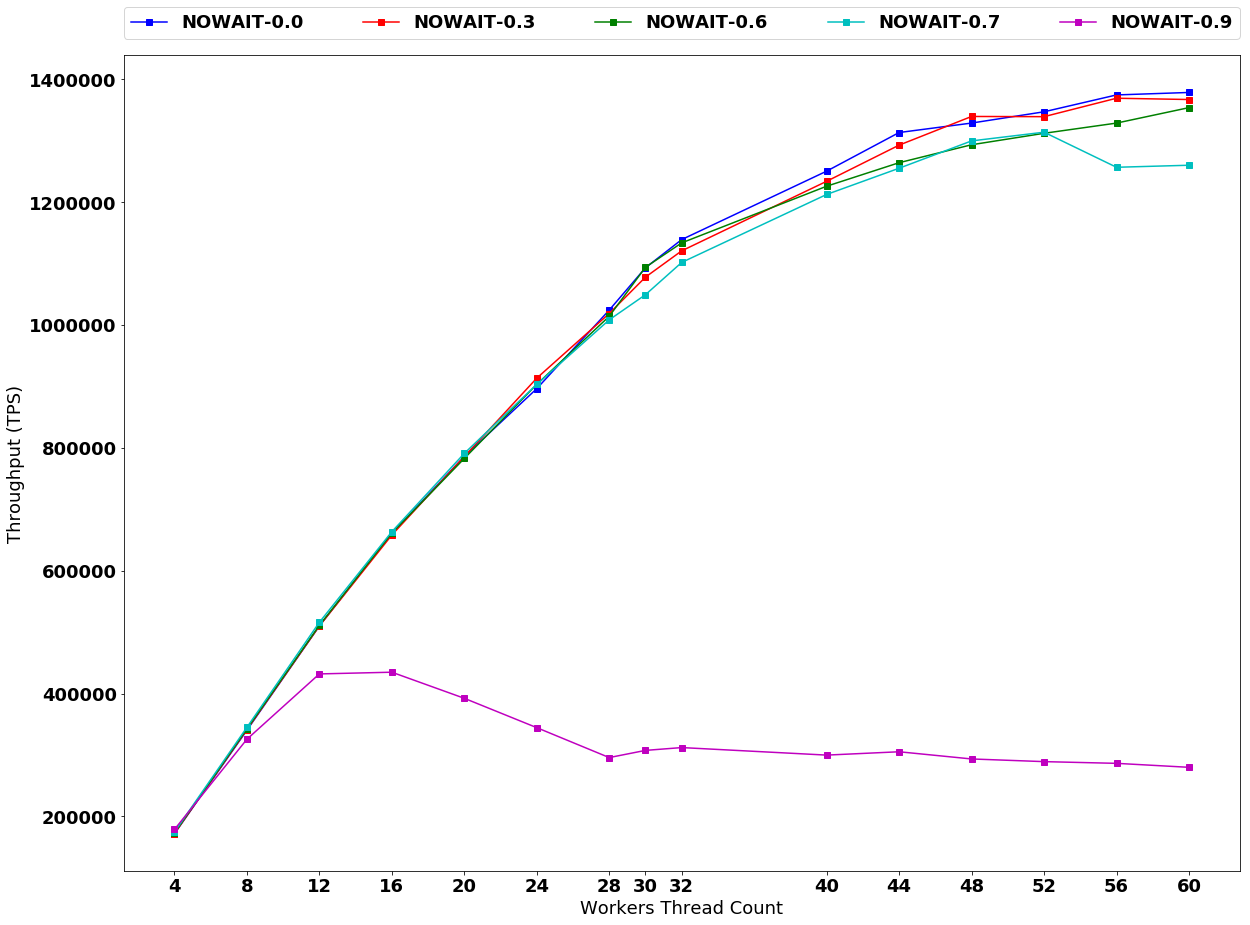

In [80]:
# grouped.loc['NOWAIT']['mean'].plot()
# theta_pt3.plot()
ls = ['bs-', 'rs-', 'gs-', 'cs-', 'ms-', 'ys-', 'bs*', 'y^--' ]
x = list(theta_pt0.index)

us = 1000000

plt.figure(figsize=(20,15))

ax = plt.subplot(111)
# pcolors = ['r','b','g','gray']
# ax.set_xscale('linear')

# for i,s in enumerate(ss):
ax.plot(x,theta_pt0, ls[0], label='NOWAIT-0.0')
ax.plot(x,theta_pt3, ls[1], label='NOWAIT-0.3')
ax.plot(x,theta_pt6, ls[2], label='NOWAIT-0.6')
ax.plot(x,theta_pt7, ls[3], label='NOWAIT-0.7')
ax.plot(x,theta_pt9, ls[4], label='NOWAIT-0.9')

ax.xaxis.set_ticks(x)
# ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.1f M'))

ax.set_ylabel('Throughput (TPS)')
ax.set_xlabel('Workers Thread Count')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=6, mode="expand", borderaxespad=0.)

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


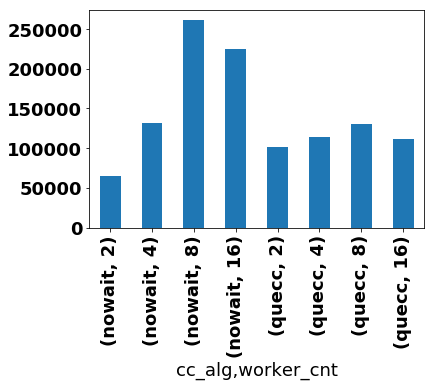

In [9]:
grouped['mean'].plot('bar')

In [10]:
grouped.loc['NOWAIT'][1:]
# grouped.loc['QUECC'][:3]

KeyError: 'the label [NOWAIT] is not in the [index]'

In [65]:
data_csv = '/Users/qadahtm/Dev/halstead/results/aws_sum_data_pt6.csv'
print(os.getcwd())
df = pd.DataFrame.from_csv(data_csv)
grouped = df.groupby(['cc_alg','wthd_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
grouped

/Users/qadahtm/Dev/halstead/deneva_project/pynb


count            min            max           mean
cc_alg    wthd_cnt                                                    
MAAT      2             1   63184.349913   63184.349913   63184.349913
          4             1  123855.666291  123855.666291  123855.666291
          8             1  243777.232635  243777.232635  243777.232635
          16            1  377311.381730  377311.381730  377311.381730
MVCC      2             1   58250.283137   58250.283137   58250.283137
          4             1  129798.216346  129798.216346  129798.216346
          8             1  260822.665445  260822.665445  260822.665445
          16            1  452140.464466  452140.464466  452140.464466
NOWAIT    2             1   83476.983176   83476.983176   83476.983176
          4             1  170251.066099  170251.066099  170251.066099
          8             1  332714.549312  332714.549312  332714.549312
          16            1  603112.180499  603112.180499  603112.180499
QUECC     1             1  164638.414353  164638.414353  164638.414353
          2             1  210285.199849  210285.199849  210285.199849
          4             1  284556.250346  284556.250346  284556.250346
          8             1  328375.932414  328375.932414  328375.932414
TIMESTAMP 2             1   87417.083228   87417.083228   87417.083228
          4             1  173877.966901  173877.966901  173877.966901
          8             1  343452.432732  343452.432732  343452.432732
          16            1  605159.430661  605159.430661  605159.430661
WAITDIE   2             1   76960.483042   76960.483042   76960.483042
          4             1  157928.683039  157928.683039  157928.683039
          8             1  313858.682313  313858.682313  313858.682313
          16            1  562928.148480  562928.148480  562928.148480

/Users/qadahtm/Dev/halstead/deneva_project/deneva/pynb
0
MAAT
1
MVCC
2
NOWAIT
3
QUECC
4
TIMESTAMP
5
WAITDIE


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


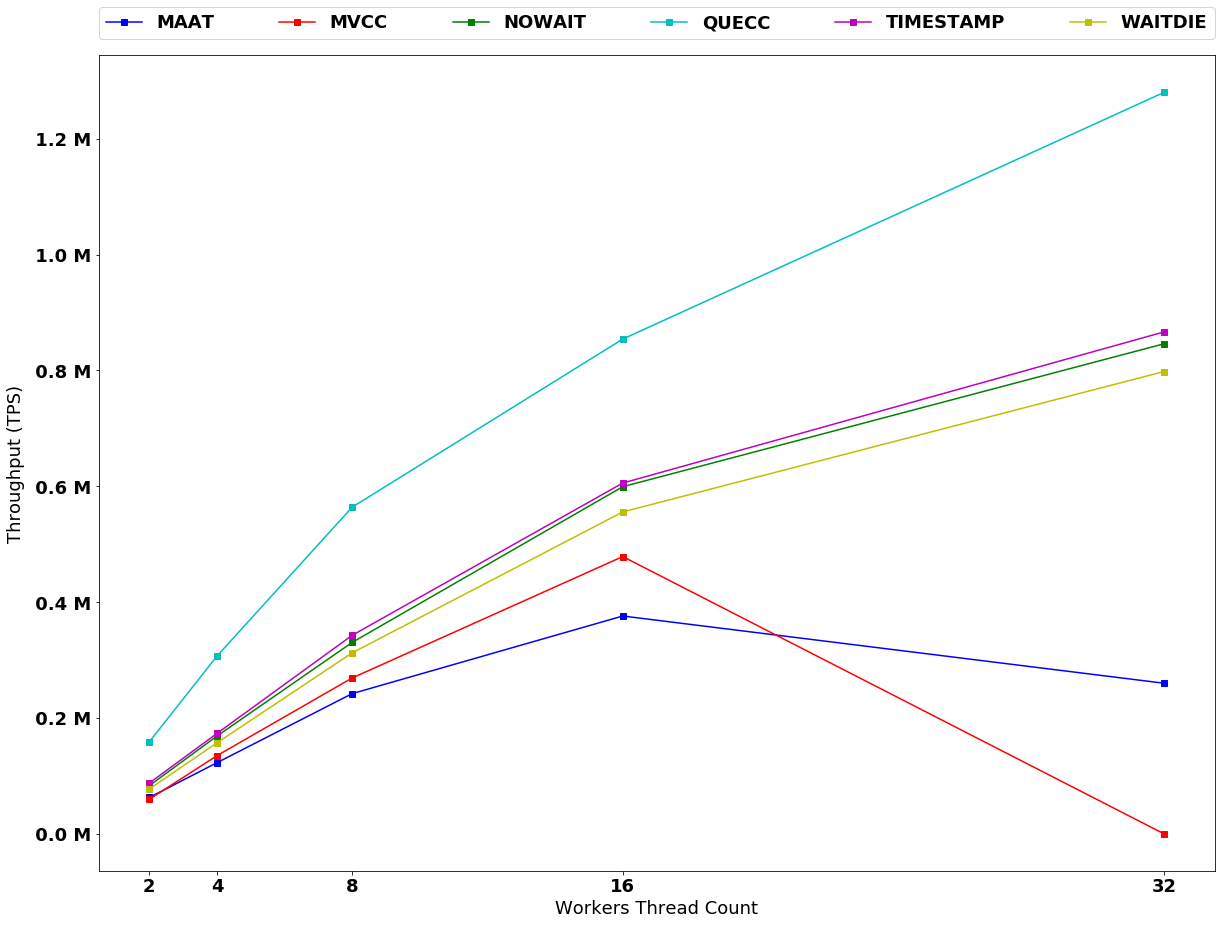

In [864]:
import matplotlib.ticker as ticker  

data_csv = '/Users/qadahtm/Dev/halstead/results/aws_sum_data_uni.csv'
print(os.getcwd())
df = pd.DataFrame.from_csv(data_csv)
grouped = df.groupby(['cc_alg','wthd_cnt']).tput.agg(['count', 'min', 'max', 'mean'])
grouped
# grouped.loc['NOWAIT']  
ss = list(grouped.index[:].levels[0])
y = [0.0]*(len(ss))
ys = [0.0]*(len(ss))
x = list(grouped.loc['NOWAIT'].index)
us = 1000000
for i,s in enumerate(ss):
    print(i)
    print(s)
    y[i] = list(grouped.loc[s]['mean'])
    ys[i] = list( map(lambda x : x/us, y[i]))
# y[0] = list(grouped.loc['NOWAIT']['mean'])
# y[1] = list(grouped.loc['QUECC']['mean'])
# y[2] = list(grouped.loc['DUMMYCC'][1:]['mean'])

# ys[0] = list( map(lambda x : x/us, y[0]))
# ys[1] = list( map(lambda x : x/us, y[1]))
# ys[2] = list( map(lambda x : x/us, y[2]))

ls = ['bs-', 'rs-', 'gs-', 'cs-', 'ms-', 'ys-', 'bs*', 'y^--' ]
plt.figure(figsize=(20,15))
# plt.figure()
ax = plt.subplot(111)
pcolors = ['r','b','g','gray']
ax.set_xscale('linear')
for i,s in enumerate(ss):
    ax.plot(x, ys[i], ls[i], label=s)

# ax.plot(x, y1s, 'bs-', label='NO_WAIT')
# ax.plot(x, y2s, 'r^-', label='QueCC')
# ax.plot(x, y3s, 'k^-', label='DummyCC')
ax.xaxis.set_ticks(x)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%4.1f M'))

ax.set_ylabel('Throughput (TPS)')
ax.set_xlabel('Workers Thread Count')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=6, mode="expand", borderaxespad=0.)

/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


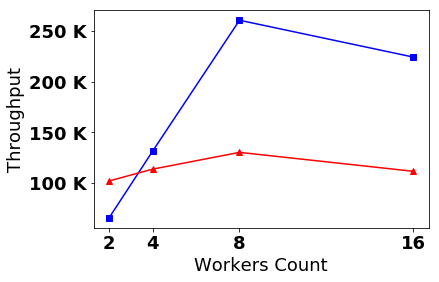

In [204]:
import matplotlib.ticker as ticker    
x = list(grouped.loc['nowait'].index)
y1 = list(grouped.loc['nowait']['mean'])
y2 = list(grouped.loc['quecc']['mean'])

y1s = list( map(lambda x : x/1000, y1))
y2s = list( map(lambda x : x/1000, y2))

# plt.figure(figsize=(20,10))
plt.figure()
ax = plt.subplot(111)
pcolors = ['r','b','g','gray']
ax.set_xscale('linear')
ax.plot(x, y1s, 'bs-')
ax.plot(x, y2s, 'r^-')
ax.xaxis.set_ticks(x)
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d K'))
# ax.set_xticks(x)
# ax.set_xticklabels(plt_buckets_keys, rotation=0)

ax.set_ylabel('Throughput')
ax.set_xlabel('Workers Count')
# plt.autoscale(tight=True)

In [31]:
directory = "/Users/qadahtm/Dev/halstead/results/quecc2"
directory = "/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/normal_mode_withdb_simple_eagersplit_ptet"
def view_planner_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
                    mq = re.search('quecc\_plan(\d+)\_(\w+)=(-?\d+\.?\d*)', a)
                    if mq:
                        row = [mq.group(1), mq.group(2), mq.group(3)]
                        key = mq.group(2)
                        if key in res.keys():
                            res[mq.group(2)].append(float(mq.group(3)))
                        else:
                            res[mq.group(2)] =[float(mq.group(3))]
#                         print(row)
#                         print(a)
#                 print(sline[0])
#                 print(sline[1])
#                 print(sline[2])
#     print(res)
    return res;
# fname = 'quecc_8p_8w_100mpr_16Mrec_s_t1.txt'
# fname = 'quecc_12p_4w_100mpr_16Mrec_s_t1.txt'
# fname = 'quecc_12p_4w_500Ktif_16Mrec_s_t1.txt'

fname = 'quecc_8p_8w_1Mtif_16Mrec_s_t1.txt'
fname = 'AFTERBATCHCOMP_pt8_et8_50_QUECC_s_t1_1_40.txt'

datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/all_neworder_tpcc_mpt_o3/pa8_AFTERBATCHCOMP_pt8_et8_50_pptstrict_QUECC_s_t0_118_32.txt'
# time_data = view_planner_from_file(directory+"/"+fname)
time_data = view_planner_from_file(datafile)
df = pd.DataFrame(time_data)
# df['idle_time']
df

,alloc_exec_queue_cnt,batch_cnt,batch_delivery_time,batch_proc_time,idle_time,mem_alloc_time,merge_time,queue_deq_cnt,queue_deq_free_mem_time,queue_deq_pop_time,queue_dequeue_time,reuse_exec_queue_cnt,size_batch_cnt,split_time,tdep_time,time_batch_cnt,total_time,txn_cnt,txn_proc_time
0,0.00,15.00,0.00,10.41,51.93,0.00,0.00,"1,171,800.00",0.00,0.34,0.38,0.00,15.00,0.64,0.00,0.00,59.06,0.00,9.86
1,0.00,15.00,0.00,10.50,51.84,0.00,0.00,"1,171,800.00",0.00,0.34,0.38,0.00,15.00,0.64,0.00,0.00,59.09,0.00,9.94
2,0.00,15.00,0.00,10.72,51.61,0.00,0.00,"1,171,800.00",0.00,0.35,0.38,0.00,15.00,0.63,0.00,0.00,59.11,0.00,10.17
3,0.00,15.00,0.00,11.08,51.20,0.00,0.00,"1,171,800.00",0.00,0.34,0.38,0.00,15.00,0.73,0.00,0.00,59.13,0.00,10.54
4,0.00,15.00,0.00,11.47,50.81,0.00,0.00,"1,171,800.00",0.00,0.35,0.39,0.00,15.00,0.63,0.00,0.00,59.16,0.00,10.92
5,0.00,15.00,0.00,11.48,50.78,0.00,0.00,"1,171,800.00",0.00,0.35,0.38,0.00,15.00,0.63,0.00,0.00,59.19,0.00,10.92
6,0.00,15.00,0.00,11.81,50.42,0.00,0.00,"1,171,800.00",0.00,0.35,0.38,0.00,15.00,0.64,0.00,0.00,59.19,0.00,11.25
7,0.00,15.00,0.00,12.35,49.81,0.00,0.00,"1,171,800.00",0.00,0.35,0.38,0.00,15.00,0.64,0.00,0.00,59.18,0.00,11.79


In [47]:
def plot_planner_times(df):
    # Create the general blog and the "subplots" i.e. the bars
    f, ax1 = plt.subplots(1, figsize=(16,5))

    # Set the bar width
    bar_width = 0.40

    colors = ['#d7191c','#fdae61','#abdda4','#2b83ba']


    # positions of the left bar-boundaries
    bar_l = [i-(bar_width) for i in range(len(df['idle_time']))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    # tick_pos = [(i-1)+(bar_width/2) for i in bar_l]

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            df['idle_time'],
            # set the width
            width=bar_width,
            # with the label pre score
            label='Idle time',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[0])

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            # using the mid_score data
            df['queue_dequeue_time'],
            # set the width
            width=bar_width,
            # with pre_score on the bottom
            bottom=df['idle_time'],
            # with the label mid score
            label='Deq. time',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[1])

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            # using the post_score data
            df['txn_proc_time'],
            # set the width
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=[i+j for i,j in zip(df['idle_time'],df['queue_dequeue_time'])],
            # with the label post score
            label='Txn proc. time',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colors[2])
    ax1.bar(bar_l,
            # using the post_score data
            [60-(i+j+k) for i,j,k in zip(df['idle_time'],df['queue_dequeue_time'], df['txn_proc_time'])],
            # set the width
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=[(i+j+k) for i,j,k in zip(df['idle_time'],df['queue_dequeue_time'], df['txn_proc_time'])],
            # with the label post score
            label='Other times',
            # with alpha 0.5
            alpha=0.5,
            # with color
            color='#000000')

    # set the x ticks with names
    plt.xticks(bar_l,['Planner_'+str(i) for i in range(len(df['idle_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Planner threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)


    # Set a buffer around the edge
#     plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

,alloc_exec_queue_cnt,batch_cnt,batch_delivery_time,batch_proc_time,idle_time,mem_alloc_time,merge_time,queue_deq_cnt,queue_deq_free_mem_time,queue_deq_pop_time,queue_dequeue_time,reuse_exec_queue_cnt,size_batch_cnt,split_time,tdep_time,time_batch_cnt,total_time,txn_cnt,txn_proc_time
0,0.00,15.00,0.00,10.41,51.93,0.00,0.00,"1,171,800.00",0.00,0.34,0.38,0.00,15.00,0.64,0.00,0.00,59.06,0.00,9.86
1,0.00,15.00,0.00,10.50,51.84,0.00,0.00,"1,171,800.00",0.00,0.34,0.38,0.00,15.00,0.64,0.00,0.00,59.09,0.00,9.94
2,0.00,15.00,0.00,10.72,51.61,0.00,0.00,"1,171,800.00",0.00,0.35,0.38,0.00,15.00,0.63,0.00,0.00,59.11,0.00,10.17
3,0.00,15.00,0.00,11.08,51.20,0.00,0.00,"1,171,800.00",0.00,0.34,0.38,0.00,15.00,0.73,0.00,0.00,59.13,0.00,10.54
4,0.00,15.00,0.00,11.47,50.81,0.00,0.00,"1,171,800.00",0.00,0.35,0.39,0.00,15.00,0.63,0.00,0.00,59.16,0.00,10.92
5,0.00,15.00,0.00,11.48,50.78,0.00,0.00,"1,171,800.00",0.00,0.35,0.38,0.00,15.00,0.63,0.00,0.00,59.19,0.00,10.92
6,0.00,15.00,0.00,11.81,50.42,0.00,0.00,"1,171,800.00",0.00,0.35,0.38,0.00,15.00,0.64,0.00,0.00,59.19,0.00,11.25
7,0.00,15.00,0.00,12.35,49.81,0.00,0.00,"1,171,800.00",0.00,0.35,0.38,0.00,15.00,0.64,0.00,0.00,59.18,0.00,11.79


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


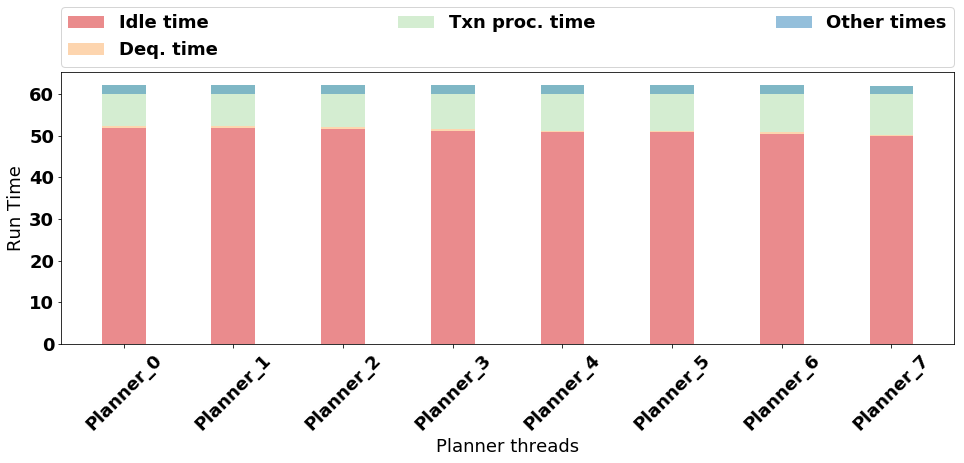

In [33]:
plot_planner_times(df)
df

In [82]:
def view_exec_from_file(_fname):
    res = {}
    with open(_fname,'r') as of:
        for line in of:
            cline = line.strip()
            m = re.search('(\[summary\]) (.+)', cline)
            if m:
                sline = m.group(2).split(',')
                for i, a in enumerate(sline):
#                     print(i,a)
#                     if i == 1:
#                         asline = a.split('=')
#                         res[asline[0]] = asline[1]
#                     mq = re.search('quecc\_exec(\d)\_(\w+)=(\d+\.?\d*)', a)
                    mq = re.search('quecc\_(exec|plan)(\d+)\_(\w+)=(\d+\.?\d*)', a)
                    if mq:
#                         res['index'].append(int(i))
                        key = "{}_{}".format(mq.group(1),mq.group(3))
                        row = [mq.group(2), key, mq.group(4)]

                        if key in res.keys():
                            res[key].append(float(mq.group(4)))
                        else:
                            res[key] =[float(mq.group(4))]
#                         print(row)
#                         print(a)
#                 print(sline[0])
#                 print(sline[1])
#                 print(sline[2])
#     print(res)
    return res;
# time_data = view_exec_from_file(directory+"/"+fname)
print(datafile)
time_data = view_exec_from_file(datafile)
df = pd.DataFrame(time_data)
df

/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test.txt


,exec_batch_cnt,exec_batch_part_cnt,exec_batch_part_proc_time,exec_batch_proc_time,exec_entry_deq_time,exec_idle_time,exec_mem_free_time,exec_resp_msg_create_time,exec_txn_cnt,exec_txn_commit_time,...,plan_queue_deq_pop_time,plan_queue_dequeue_time,plan_reuse_exec_queue_cnt,plan_size_batch_cnt,plan_split_time,plan_tdep_time,plan_time_batch_cnt,plan_total_time,plan_txn_cnt,plan_txn_proc_time
0,"1,799.00","28,794.00",0.00,0.00,1.62,3.31,0.08,0.00,0.00,6.41,...,0.74,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.74
1,"1,799.00","28,794.00",0.00,0.00,1.67,3.38,0.08,0.00,0.00,6.39,...,0.70,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.71
2,"1,799.00","28,794.00",0.00,0.00,1.57,3.24,0.08,0.00,0.00,6.41,...,0.69,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.79
3,"1,799.00","28,794.00",0.00,0.00,1.66,3.30,0.08,0.00,0.00,6.41,...,0.68,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.75
4,"1,799.00","28,794.00",0.00,0.00,1.56,3.33,0.07,0.00,0.00,6.38,...,0.68,0.65,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.73
5,"1,799.00","28,794.00",0.00,0.00,1.54,3.21,0.07,0.00,0.00,6.42,...,0.68,0.67,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.79
6,"1,799.00","28,794.00",0.00,0.00,1.28,3.19,0.07,0.00,0.00,6.41,...,0.68,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.81
7,"1,799.00","28,794.00",0.00,0.00,1.76,3.36,0.07,0.00,0.00,6.39,...,0.68,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.70
8,"1,799.00","28,794.00",0.00,0.00,1.74,3.29,0.07,0.00,0.00,6.42,...,0.70,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.75
9,"1,799.00","28,794.00",0.00,0.00,1.77,3.51,0.07,0.00,0.00,6.17,...,0.68,0.67,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.78


In [83]:
def plot_exec_times(df):
    f, ax1 = plt.subplots(1, figsize=(15,5))

    # Set the bar width
    bar_width = 0.75

    colors = ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd', '#000000']


    # positions of the left bar-boundaries
    bar_l = [i-(0.75) for i in range(len(df['idle_time']))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    # tick_pos = [(i-1)+(bar_width/2) for i in bar_l]

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            df['idle_time'],
            width=bar_width,
            label='Idle time',
            color=colors[0])

    # show whole batch partition processing
#     ax1.bar(bar_l,
#             df['batch_part_proc_time'],
#             width=bar_width,
#             bottom=df['idle_time'],
#             label='Batch part. proc. time',
#             color=colors[1])

# txn_index_lookup_time
    ax1.bar(bar_l,
            df['txn_index_lookup_time'],
            width=bar_width,
            bottom=df['idle_time'],
            label='Index lookup time',
            color=colors[1], hatch='//')

    # txn_proc_time
    ax1.bar(bar_l,
            df['txn_proc_time'],
            width=bar_width,
            bottom=[(i+j) for i,j in zip(df['idle_time'],df['txn_index_lookup_time'])],
            label='Txn. proc. time',
            color=colors[2], hatch='\\')
    
    # txn_ctx_update_time
    ax1.bar(bar_l,
            df['txn_ctx_update_time'],
            width=bar_width,
            bottom=[(i+j+k) for i,j,k in zip(df['idle_time'],df['txn_index_lookup_time'],df['txn_proc_time'])],
            label='Update txn. ctx. time',
            color=colors[3], hatch='|')
    
    # txn_commit_time
    ax1.bar(bar_l,
            df['txn_commit_time'],
            width=bar_width,
            bottom=[(i+j+k+m) for i,j,k,m in zip(df['idle_time'],df['txn_index_lookup_time'],
                                                 df['txn_proc_time'], df['txn_ctx_update_time'])],
            label='Commit time',
            color=colors[4], hatch='=')
    
    # wait_times
    ax1.bar(bar_l,
            df['txn_wait_time'],
            width=bar_width,
            bottom=[(i+j+k+m+n) for i,j,k,m,n in zip(df['idle_time'],df['txn_index_lookup_time'],
                                                 df['txn_proc_time'], df['txn_ctx_update_time'],
                                                     df['txn_commit_time'])],
            label='Wait time',
            color=colors[5], hatch='=')

    
    ax1.bar(bar_l,
            [60-(i+j+k+m+n+o) if (i+j+k+m+n+o) <= 60 else 0 for i,j,k,m,n,o in zip(df['idle_time'],
                                                 df['txn_index_lookup_time'],
                                                 df['txn_proc_time'],
                                                 df['txn_ctx_update_time'],
                                                 df['txn_commit_time'],
                                                 df['txn_wait_time'])],
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=[(i+j+k+m+n+o) for i,j,k,m,n,o in zip(df['idle_time'],
                                                 df['txn_index_lookup_time'],
                                                 df['txn_proc_time'],
                                                 df['txn_ctx_update_time'],
                                                 df['txn_commit_time'],
                                                 df['txn_wait_time'])],
            label='Other times',
            color=colors[6], hatch='++')

    # set the x ticks with names
    plt.xticks(bar_l,['ET_'+str(i) for i in range(len(df['idle_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Execution threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)


    # Set a buffer around the edge
#     plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])

In [129]:
def plot_exec_times_single_stage(df):
    f, ax1 = plt.subplots(1, figsize=(15,5))

    # Set the bar width
    bar_width = 0.75

    colors = ['#d53e4f','#fc8d59','#fee08b','#e6f598','#99d594','#3288bd', '#CCCCCC']


    # positions of the left bar-boundaries
    bar_l = [i-(0.75) for i in range(len(df['exec_idle_time']))]

    # positions of the x-axis ticks (center of the bars as bar labels)
    # tick_pos = [(i-1)+(bar_width/2) for i in bar_l]

    # Create a bar plot, in position bar_1
    ax1.bar(bar_l,
            df['exec_idle_time']+df['plan_idle_time'],
            width=bar_width,
            label='Idle time',
            color=colors[0])

    # show whole batch partition processing
#     ax1.bar(bar_l,
#             df['batch_part_proc_time'],
#             width=bar_width,
#             bottom=df['idle_time'],
#             label='Batch part. proc. time',
#             color=colors[1])

    ax1.bar(bar_l,
            df['plan_txn_proc_time'],
            width=bar_width,
            bottom=df['exec_idle_time']+df['plan_idle_time'],
            label='Plan. txn. proc. time',
            color=colors[1], hatch='//')

    # txn_proc_time
    ax1.bar(bar_l,
            df['exec_txn_proc_time'],
            width=bar_width,
            bottom=(df['exec_idle_time']+df['plan_idle_time']
                    +df['plan_txn_proc_time']),
            label='Exec. txn. proc. time',
            color=colors[2], hatch='\\')
    
    # txn_ctx_update_time
    ax1.bar(bar_l,
            df['exec_txn_ctx_update_time'],
            width=bar_width,
            bottom=(df['exec_idle_time']
                    +df['plan_idle_time']
                    +df['exec_txn_proc_time']
                    +df['plan_txn_proc_time']
                    +df['exec_txn_index_lookup_time']),
            label='Txn context updates',
            color=colors[3], hatch='|')
    
    # txn_commit_time
    ax1.bar(bar_l,
            df['exec_txn_commit_time'],
            width=bar_width,
            bottom=(df['exec_txn_ctx_update_time']
                    +df['exec_idle_time']
                    +df['plan_idle_time']
                    +df['exec_txn_proc_time']
                    +df['plan_txn_proc_time']
                    +df['exec_txn_index_lookup_time']),
            label='Commit time',
            color=colors[4], hatch='=')
    
    # wait_times
    ax1.bar(bar_l,
            df['exec_txn_wait_time'],
            width=bar_width,
            bottom=(df['exec_txn_commit_time']
                    +df['exec_txn_ctx_update_time']
                    +df['exec_idle_time']
                    +df['plan_idle_time']
                    +df['exec_txn_proc_time']
                    +df['plan_txn_proc_time']
                    +df['exec_txn_index_lookup_time']),
            label='Wait time',
            color=colors[5], hatch='=')

    all_df = (df['exec_txn_wait_time']+df['exec_txn_commit_time']+df['exec_txn_ctx_update_time']+df['exec_idle_time']+df['plan_idle_time']+df['exec_txn_proc_time']
                +df['plan_txn_proc_time']
                +df['exec_txn_index_lookup_time']);

                    
    ax1.bar(bar_l,
            (60-all_df),
            width=bar_width,
            # with pre_score and mid_score on the bottom
            bottom=(all_df),
            label='Other times',
            color=colors[6], hatch='++')

    # set the x ticks with names
    plt.xticks(bar_l,['ET_'+str(i) for i in range(len(df['exec_idle_time']))], rotation=45)

    # Set the label and legends
    ax1.set_ylabel("Run Time")
    ax1.set_xlabel("Execution threads")
    # plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.)

151116.0


,alloc_exec_queue_cnt,batch_cnt,batch_delivery_time,batch_proc_time,idle_time,mem_alloc_time,merge_time,queue_deq_cnt,queue_deq_free_mem_time,queue_deq_pop_time,queue_dequeue_time,reuse_exec_queue_cnt,size_batch_cnt,split_time,tdep_time,time_batch_cnt,total_time,txn_cnt,txn_proc_time
0,0.00,"1,799.00",0.00,"10,613,305.74",0.00,0.10,0.02,"566,685.00",0.00,0.74,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.74
1,0.00,"1,799.00",0.00,"10,613,305.70",0.00,0.10,0.02,"566,685.00",0.00,0.70,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.71
2,0.00,"1,799.00",0.00,"10,613,305.82",0.00,0.10,0.02,"566,685.00",0.00,0.69,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.79
3,0.00,"1,799.00",0.00,"10,613,305.77",0.00,0.10,0.02,"566,685.00",0.00,0.68,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.75
4,0.00,"1,799.00",0.00,"10,613,305.74",0.00,0.10,0.02,"566,685.00",0.00,0.68,0.65,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.73
5,0.00,"1,799.00",0.00,"10,613,305.81",0.00,0.10,0.02,"566,685.00",0.00,0.68,0.67,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.79
6,0.00,"1,799.00",0.00,"10,613,305.82",0.00,0.10,0.02,"566,685.00",0.00,0.68,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.81
7,0.00,"1,799.00",0.00,"10,613,305.72",0.00,0.11,0.02,"566,685.00",0.00,0.68,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.70
8,0.00,"1,799.00",0.00,"10,613,305.76",0.00,0.10,0.02,"566,685.00",0.00,0.70,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.75
9,0.00,"1,799.00",0.00,"10,613,305.79",0.00,0.10,0.02,"566,685.00",0.00,0.68,0.67,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.78


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


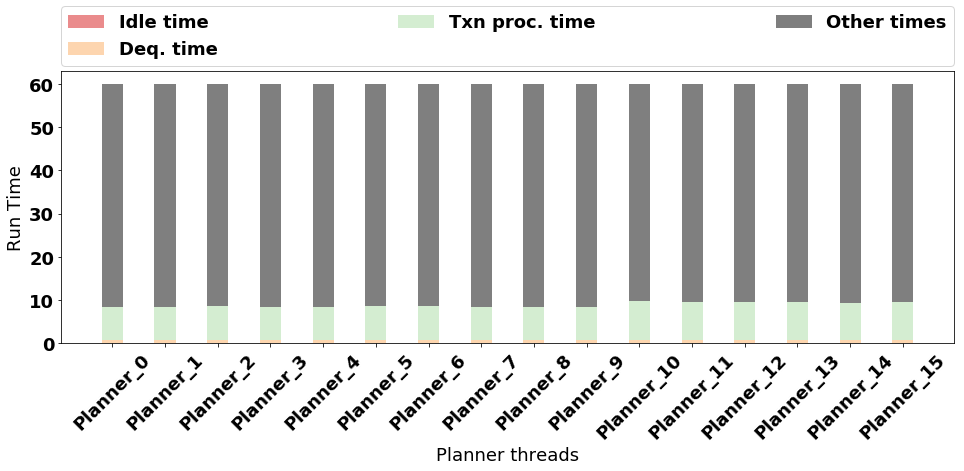

In [130]:
# directory = '/Users/qadahtm/Dev/halstead/results/quecc_aws'
# df = pd.DataFrame(view_planner_from_file(directory+"/QUECC_s_t0_7.txt"))
datafile = '/Users/qadahtm/Dev/halstead/deneva_project/deneva/exp_results/test.txt'
df = pd.DataFrame(view_planner_from_file(datafile))
plot_planner_times(df)
print(df['queue_deq_cnt'].sum()/60)
df

,exec_batch_cnt,exec_batch_part_cnt,exec_batch_part_proc_time,exec_batch_proc_time,exec_entry_deq_time,exec_idle_time,exec_mem_free_time,exec_resp_msg_create_time,exec_txn_cnt,exec_txn_commit_time,...,plan_queue_deq_pop_time,plan_queue_dequeue_time,plan_reuse_exec_queue_cnt,plan_size_batch_cnt,plan_split_time,plan_tdep_time,plan_time_batch_cnt,plan_total_time,plan_txn_cnt,plan_txn_proc_time
0,"1,799.00","28,794.00",0.00,0.00,1.62,3.31,0.08,0.00,0.00,6.41,...,0.74,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.74
1,"1,799.00","28,794.00",0.00,0.00,1.67,3.38,0.08,0.00,0.00,6.39,...,0.70,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.71
2,"1,799.00","28,794.00",0.00,0.00,1.57,3.24,0.08,0.00,0.00,6.41,...,0.69,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.79
3,"1,799.00","28,794.00",0.00,0.00,1.66,3.30,0.08,0.00,0.00,6.41,...,0.68,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.75
4,"1,799.00","28,794.00",0.00,0.00,1.56,3.33,0.07,0.00,0.00,6.38,...,0.68,0.65,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.73
5,"1,799.00","28,794.00",0.00,0.00,1.54,3.21,0.07,0.00,0.00,6.42,...,0.68,0.67,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.79
6,"1,799.00","28,794.00",0.00,0.00,1.28,3.19,0.07,0.00,0.00,6.41,...,0.68,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.81
7,"1,799.00","28,794.00",0.00,0.00,1.76,3.36,0.07,0.00,0.00,6.39,...,0.68,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.70
8,"1,799.00","28,794.00",0.00,0.00,1.74,3.29,0.07,0.00,0.00,6.42,...,0.70,0.66,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.75
9,"1,799.00","28,794.00",0.00,0.00,1.77,3.51,0.07,0.00,0.00,6.17,...,0.68,0.67,0.00,0.00,0.29,0.00,0.00,0.00,0.00,7.78


/Users/qadahtm/.pyenv/versions/3.6.1/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


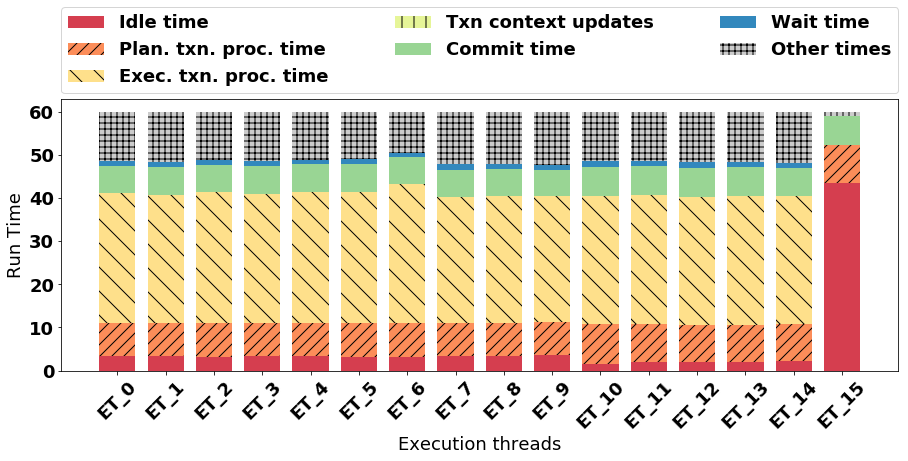

In [131]:
# directory = '/Users/qadahtm/Dev/halstead/results/quecc_aws'
# df = pd.DataFrame(view_exec_from_file(directory+"/QUECC_s_t0_7.txt"))
df = pd.DataFrame(view_exec_from_file(datafile))
# plot_exec_times(df)
plot_exec_times_single_stage(df)
df

In [264]:
(df['txn_frag_cnt']/10)/df['batch_cnt']

0    325.931231
1    325.937488
2    325.930243
3    324.373538
dtype: float64

In [269]:
tput_sample = {'dummy_cc':274743.599657, 'quecc':263500.982947, 'no_wait':261938.732251} -- 8 threads
tput_sample

{'dummy_cc': 274743.599657}

In [207]:
sample_res = {'w_thds':[2,4,8,16],
              'dummy_cc':[],
              'no_wait':[],
              'quecc':[]}

148.2495267939766

In [272]:
'NO_WAIT'.replace('_','')

'NOWAIT'

In [275]:
# Import smtplib for the actual sending function
import smtplib

# Import the email modules we'll need
# from email.message import EmailMessage

# def send_email(msg):
#     s = smtplib.SMTP('localhost')
#     s.sendmail('tqadah@purdue.edu', ['tqadah@purdue.edu'], msg)
#     s.quit()

# send_email('test content')
# msg = EmailMessage()
# msg.set_content("test content")

# me == the sender's email address
# you == the recipient's email address
# msg['Subject'] = 'subjet test'
# msg['From'] = 'tqadah@purdue.edu'
# msg['To'] = ['tqadah@purdue.edu', 'qadah.thamir@gmail.com']

# # Send the message via our own SMTP server.
# s = smtplib.SMTP('localhost')
# s.send_message(msg)
# s.quit()

ConnectionRefusedError: [Errno 61] Connection refused

In [82]:
cc_algs = ['NO_WAIT', 'QUECC', 'WAIT_DIE', 'TIMESTAMP', 'MVCC', 'CALVIN' , 'MAAT' ]
# cc_algs = ['DUMMY_CC']
wthreads = [1,2,4,8,16]
for ncc_alg in cc_algs:
    for wthd in wthreads:
        runexp = True
        if wthd == 1  and ncc_alg != 'QUECC':
            #Don't run other CCs with 1 thread 
            runexp = False

        if wthd == 16 and ncc_alg == 'QUECC':
            #Don't run QueCC with 16 threads 
            runexp = False
        if runexp:       
            print('Run exp: {}, for thd = {}, cc={}'.format(runexp, wthd, ncc_alg))

Run exp: True, for thd = 2, cc=NO_WAIT
Run exp: True, for thd = 4, cc=NO_WAIT
Run exp: True, for thd = 8, cc=NO_WAIT
Run exp: True, for thd = 16, cc=NO_WAIT
Run exp: True, for thd = 1, cc=QUECC
Run exp: True, for thd = 2, cc=QUECC
Run exp: True, for thd = 4, cc=QUECC
Run exp: True, for thd = 8, cc=QUECC
Run exp: True, for thd = 2, cc=WAIT_DIE
Run exp: True, for thd = 4, cc=WAIT_DIE
Run exp: True, for thd = 8, cc=WAIT_DIE
Run exp: True, for thd = 16, cc=WAIT_DIE
Run exp: True, for thd = 2, cc=TIMESTAMP
Run exp: True, for thd = 4, cc=TIMESTAMP
Run exp: True, for thd = 8, cc=TIMESTAMP
Run exp: True, for thd = 16, cc=TIMESTAMP
Run exp: True, for thd = 2, cc=MVCC
Run exp: True, for thd = 4, cc=MVCC
Run exp: True, for thd = 8, cc=MVCC
Run exp: True, for thd = 16, cc=MVCC
Run exp: True, for thd = 2, cc=CALVIN
Run exp: True, for thd = 4, cc=CALVIN
Run exp: True, for thd = 8, cc=CALVIN
Run exp: True, for thd = 16, cc=CALVIN
Run exp: True, for thd = 2, cc=MAAT
Run exp: True, for thd = 4, cc=MAAT

In [90]:
pt_cnt = 8
et_cnt = pt_cnt
part_cnt = 5

q_cnt = 10
for i in range(q_cnt):
    for pl_id in range(pl_cnt):
        part = (pl_id + (pl_cnt*i)) % part_cnt
        
        out = "({},{}) = {}".format(pl_id,i, part)
#         print(out)


out = 2*(35*100000)/60
print(out)

116666.66666666667


In [119]:
table_size = 100
part_cnt = 7
rows_per_part = table_size / part_cnt
print(int(rows_per_part))
q_cnt = 200
for i in range(q_cnt):
    part = int(i /rows_per_part) % part_cnt
    out = "({}) = {}".format(i, part)
    print(out)

14
(0) = 0
(1) = 0
(2) = 0
(3) = 0
(4) = 0
(5) = 0
(6) = 0
(7) = 0
(8) = 0
(9) = 0
(10) = 0
(11) = 0
(12) = 0
(13) = 0
(14) = 0
(15) = 1
(16) = 1
(17) = 1
(18) = 1
(19) = 1
(20) = 1
(21) = 1
(22) = 1
(23) = 1
(24) = 1
(25) = 1
(26) = 1
(27) = 1
(28) = 1
(29) = 2
(30) = 2
(31) = 2
(32) = 2
(33) = 2
(34) = 2
(35) = 2
(36) = 2
(37) = 2
(38) = 2
(39) = 2
(40) = 2
(41) = 2
(42) = 2
(43) = 3
(44) = 3
(45) = 3
(46) = 3
(47) = 3
(48) = 3
(49) = 3
(50) = 3
(51) = 3
(52) = 3
(53) = 3
(54) = 3
(55) = 3
(56) = 3
(57) = 3
(58) = 4
(59) = 4
(60) = 4
(61) = 4
(62) = 4
(63) = 4
(64) = 4
(65) = 4
(66) = 4
(67) = 4
(68) = 4
(69) = 4
(70) = 4
(71) = 4
(72) = 5
(73) = 5
(74) = 5
(75) = 5
(76) = 5
(77) = 5
(78) = 5
(79) = 5
(80) = 5
(81) = 5
(82) = 5
(83) = 5
(84) = 5
(85) = 5
(86) = 6
(87) = 6
(88) = 6
(89) = 6
(90) = 6
(91) = 6
(92) = 6
(93) = 6
(94) = 6
(95) = 6
(96) = 6
(97) = 6
(98) = 6
(99) = 6
(100) = 0
(101) = 0
(102) = 0
(103) = 0
(104) = 0
(105) = 0
(106) = 0
(107) = 0
(108) = 0
(109) = 0
(110) =

In [160]:
pt_cnt = 8
et_cnt = pt_cnt
batch_size = 128

txn_per_pg = int(batch_size / pt_cnt)
txn_per_et = int(txn_per_pg / et_cnt)
txn_id = 0
for j in range(pt_cnt):
    for k in range(txn_per_pg):
        txn_id = ((j*txn_per_pg)+k)
        et_id = int(txn_id / txn_per_et) % et_cnt
        out = "PG ({}) : for txn_id = {}, it is committed by {}".format(j, txn_id, et_id)
        print(out)
#         txn_id = txn_id +1
    
# for i in range(et_cnt):
#     for j in range(pt_cnt):
#         "({},{})"




PG (0) : for txn_id = 0, it is committed by 0
PG (0) : for txn_id = 1, it is committed by 0
PG (0) : for txn_id = 2, it is committed by 1
PG (0) : for txn_id = 3, it is committed by 1
PG (0) : for txn_id = 4, it is committed by 2
PG (0) : for txn_id = 5, it is committed by 2
PG (0) : for txn_id = 6, it is committed by 3
PG (0) : for txn_id = 7, it is committed by 3
PG (0) : for txn_id = 8, it is committed by 4
PG (0) : for txn_id = 9, it is committed by 4
PG (0) : for txn_id = 10, it is committed by 5
PG (0) : for txn_id = 11, it is committed by 5
PG (0) : for txn_id = 12, it is committed by 6
PG (0) : for txn_id = 13, it is committed by 6
PG (0) : for txn_id = 14, it is committed by 7
PG (0) : for txn_id = 15, it is committed by 7
PG (1) : for txn_id = 16, it is committed by 0
PG (1) : for txn_id = 17, it is committed by 0
PG (1) : for txn_id = 18, it is committed by 1
PG (1) : for txn_id = 19, it is committed by 1
PG (1) : for txn_id = 20, it is committed by 2
PG (1) : for txn_id = 2

In [183]:
cc_algs = ['SILO', 'WAIT_DIE', 'MVCC', 'CALVIN']
note = "CC_ALG: {}".format(",".join(cc_algs))
print(note)

CC_ALG: SILO,WAIT_DIE,MVCC,CALVIN


In [2]:
def lcm(x, y):
   if x > y:
       z = x
   else:
       z = y

   while(True):
       if((z % x == 0) and (z % y == 0)):
           lcm = z
           break
       z += 1
   return lcm
print(lcm(4, 6))
print(lcm(15, 17))

12
255


In [3]:
part_cnt = [2,4,6,8,10,12,14,16,18,20,24,28,30,32,36,40,48,56,62,64,72,80,84,96,104,112,120,126]
# part_cnt =[]
# for i in range(128):
#     if i > 2:
#         part_cnt.append(i)
print(part_cnt)
it = iter(part_cnt)
k = lcm(2,4)
for i in it:
    j = next(it)
    k = lcm(j,k)
    print("{},{} = {}".format(i,j,k))    


[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28, 30, 32, 36, 40, 48, 56, 62, 64, 72, 80, 84, 96, 104, 112, 120, 126]
2,4 = 4
6,8 = 8
10,12 = 24
14,16 = 48
18,20 = 240
24,28 = 1680
30,32 = 3360
36,40 = 3360
48,56 = 3360
62,64 = 6720
72,80 = 6720
84,96 = 6720
104,112 = 6720
120,126 = 20160
